In [1]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

import glob
from astropy.io import ascii

In [2]:
lienObj = glob.glob("/renoir_data_02/jpreyes/lsst_data/light_curves/multicolour_set/*.dat")

lcs = []
for oj in lienObj:
    table = ascii.read(oj)
    lcs.append(table)


This is the colour map. You can modify these values to change the light curve point colors.

In [4]:
stack_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

Loading of SNLS Data

In [3]:
s07_file = open('07D3Season.dat')
lst = []
for line in s07_file:
    lst += [line.split()]
    
coordinates = [x[1]+" "+x[2] for x in lst]

In [11]:
import astropy.coordinates as coord
import astropy.units as u
snls_data = []
for data in coordinates:
    c = coord.SkyCoord(data, unit=(u.hourangle, u.deg))
    snls_data.append({"ra":c.ra.deg,"dec":c.dec.deg})

In [12]:
snls_data

[{'dec': 52.52421388888889, 'ra': 214.39042499999996},
 {'dec': 53.102494444444446, 'ra': 214.77087499999996},
 {'dec': 52.38538333333333, 'ra': 214.54277916666663},
 {'dec': 52.343672222222224, 'ra': 215.24336666666665},
 {'dec': 52.970463888888894, 'ra': 215.35716249999996},
 {'dec': 52.48034166666667, 'ra': 215.2254333333333},
 {'dec': 52.53961111111111, 'ra': 214.07189583333331},
 {'dec': 53.08396388888889, 'ra': 214.1495875},
 {'dec': 52.317936111111116, 'ra': 214.55342083333332},
 {'dec': 52.67514444444444, 'ra': 215.32593749999995},
 {'dec': 52.25371111111111, 'ra': 215.2355458333333},
 {'dec': 52.27128888888889, 'ra': 215.0259833333333},
 {'dec': 53.037413888888885, 'ra': 215.66997916666665},
 {'dec': 52.74682777777778, 'ra': 215.14867916666665},
 {'dec': 52.66885555555555, 'ra': 215.2754833333333},
 {'dec': 52.66885555555555, 'ra': 215.2754833333333},
 {'dec': 52.466100000000004, 'ra': 214.8921208333333},
 {'dec': 53.07664444444445, 'ra': 214.8289333333333},
 {'dec': 53.177805

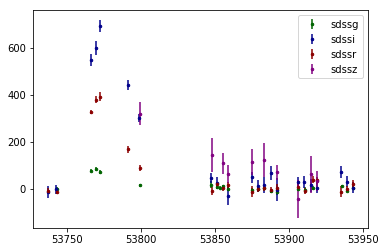

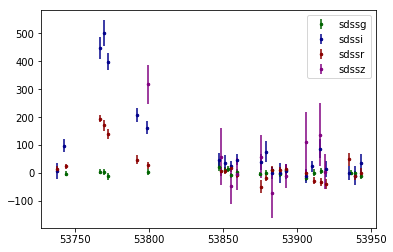

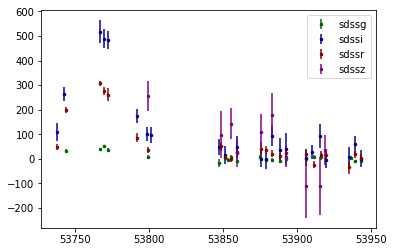

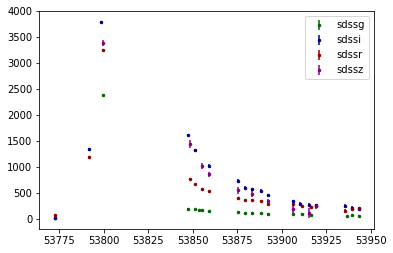

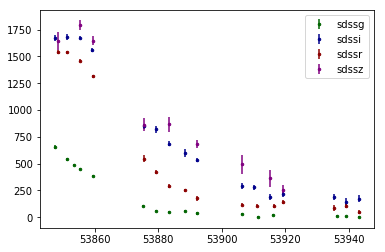

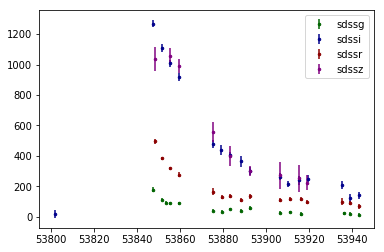

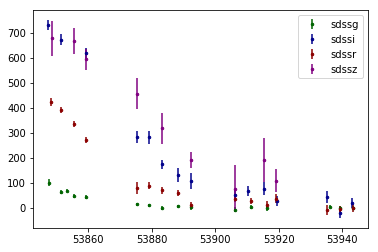

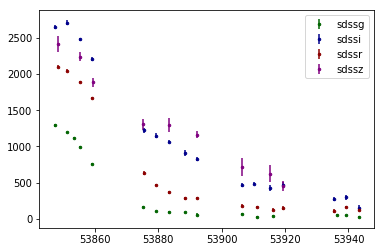

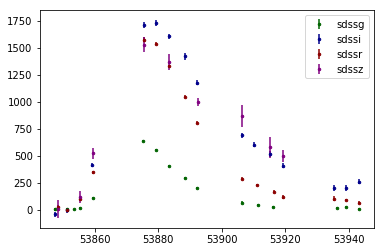

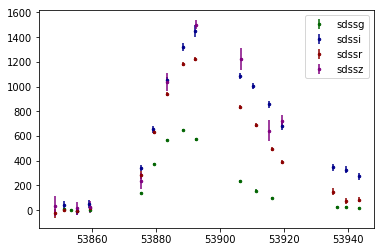

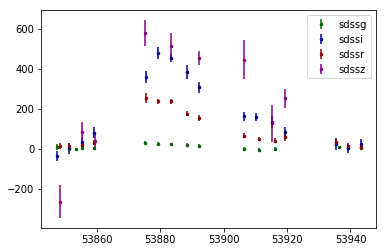

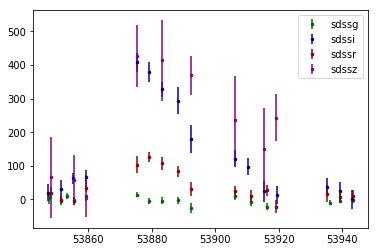

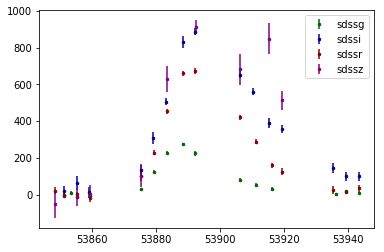

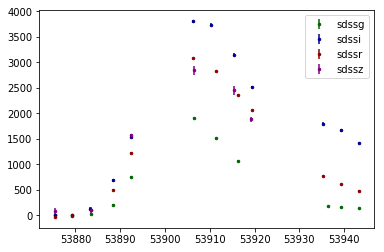

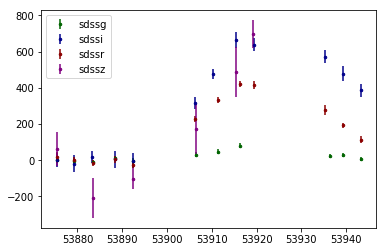

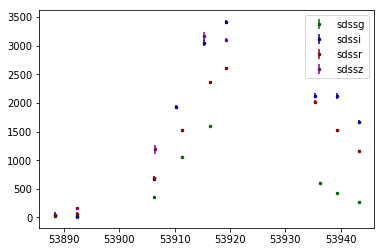

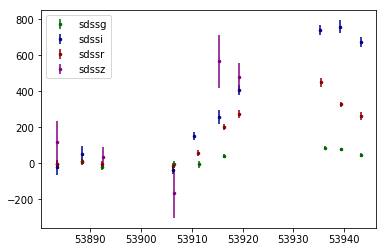

In [7]:
%matplotlib inline
import re
import astropy.coordinates as coord
import astropy.units as u


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|(r|g|i|z)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
    
    #print m
    #print sn[0], c.ra.deg, c.dec.deg
    
    #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    show_multi_filter_light_curve(snls_lc, snls_colors)
    plt.show()
    snls_array.append(snls_lc)

These methods allow the visualization and normalization

In [11]:
from scipy.stats import sigmaclip
import sys 
def show_multi_filter_light_curve(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    #print indices

    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()
    
def show_filter_light_curve(lc1, colors, filter, n_factor = None, m_size=5):
    l1 = lc1[lc1['bandpass']==filter]
    
    if n_factor is not None:
            f = n_factor if np.isnan(n_factor) == False else 1
            plt.errorbar(l1["mjd"], l1["flux"]*f,yerr=l1["flux_error"]*f, fmt='.', markersize=m_size, label=filter, c=colors[filter])            
    else:
            plt.errorbar(l1["mjd"], l1["flux"],yerr=l1["flux_error"], fmt='.', markersize=m_size, label=filter, c=colors[filter])
    
    
def normalize_light_curve(lc1, lc2, filter):
   
    l1 = lc1[lc1['bandpass']==filter]
    l2 = lc2[lc2['bandpass']==filter]
    norm = []
    for row1 in l1:
        for row2 in l2:
            if int(row1["mjd"]) == int(row2["mjd"]):
                norm.append(row1["flux"]/row2["flux"])
                
    c_array = sigmaclip(norm, low=1.5, high=1.5)
    return c_array.clipped.mean()

def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
       
            val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
            #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
            for i, slc in enumerate(stack_lc):
                    #print i
                    comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
                    if DSTools.source_distance(val, comp)<1:
                        print i
                        matches.append((lc,slc))
                

    print len(matches)
    return matches

Matching the light curves with snls data

In [13]:
len(lcs)

NameError: name 'lcs' is not defined

In [8]:
matches_45= match_with_lc(snls_array, lcs)

1371
14132
16425
12099
4760
1982
7388
16215
16242
12577
7894
14637
12819
10057
16530
16552
8316
4443
5024
5043
7372
21


This is the complete visualization,

214.2919202 53.0247723995
{'sdssi': 26.397506721419525, 'sdssr': 19.337540002953133, 'sdssz': nan, 'sdssg': 17.624876027868396}


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-

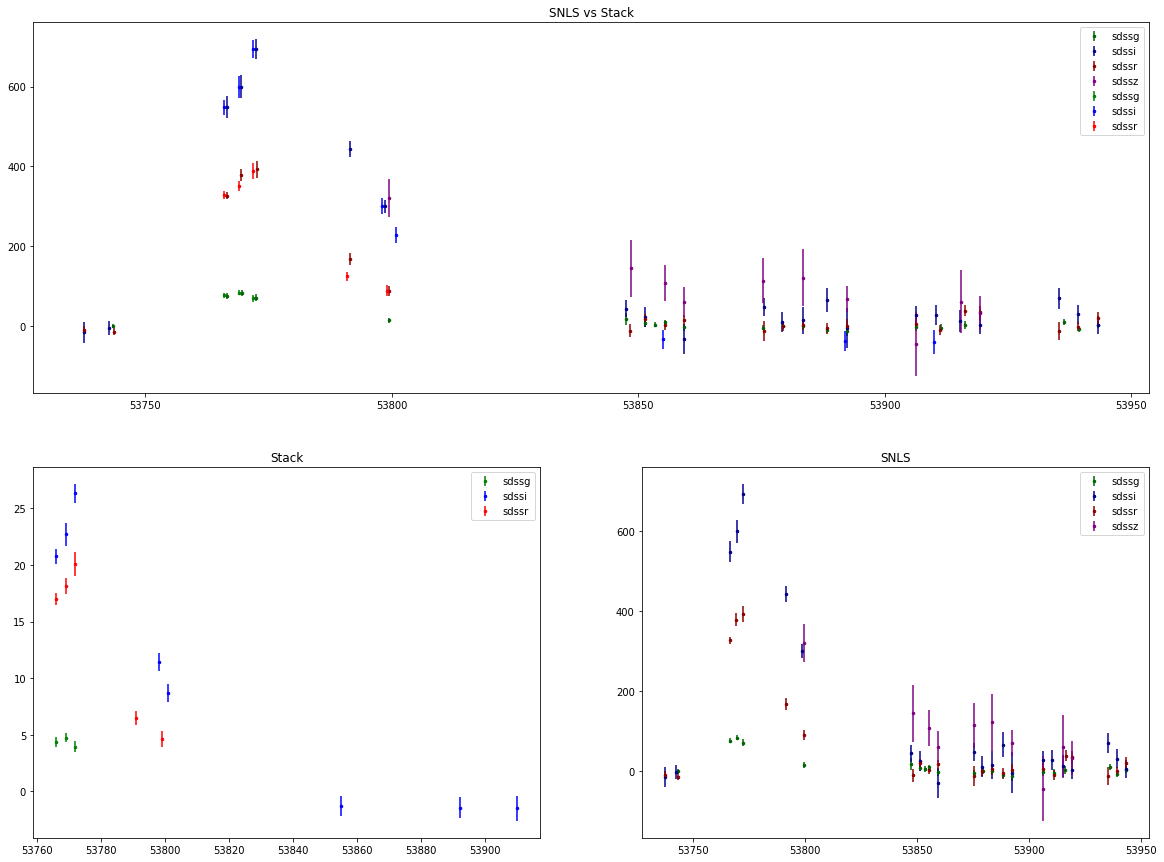

215.181501398 52.191088095
{'sdssi': 4.2504142489611967, 'sdssr': 21.58044334981528, 'sdssz': nan, 'sdssg': nan}


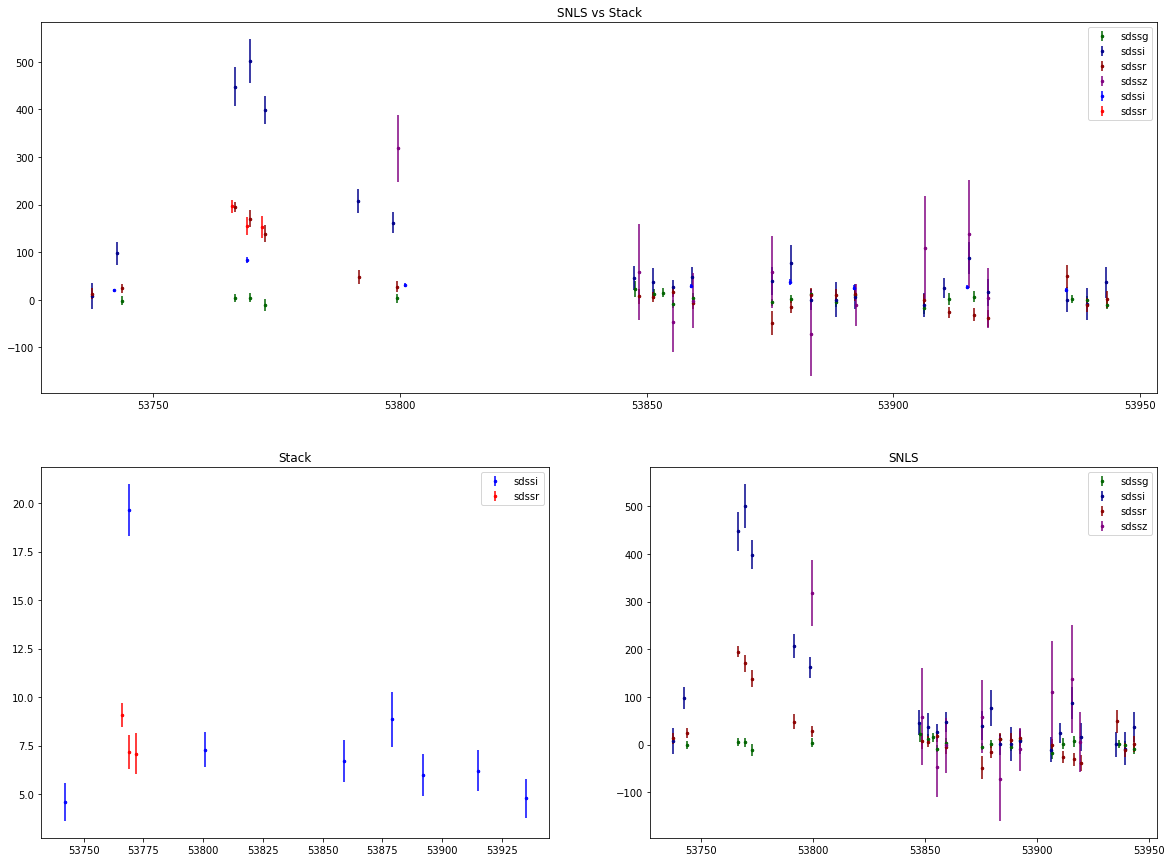

214.381746194 52.9124055775
{'sdssi': 26.015140122231557, 'sdssr': 22.187396064875252, 'sdssz': nan, 'sdssg': 11.873956047502338}


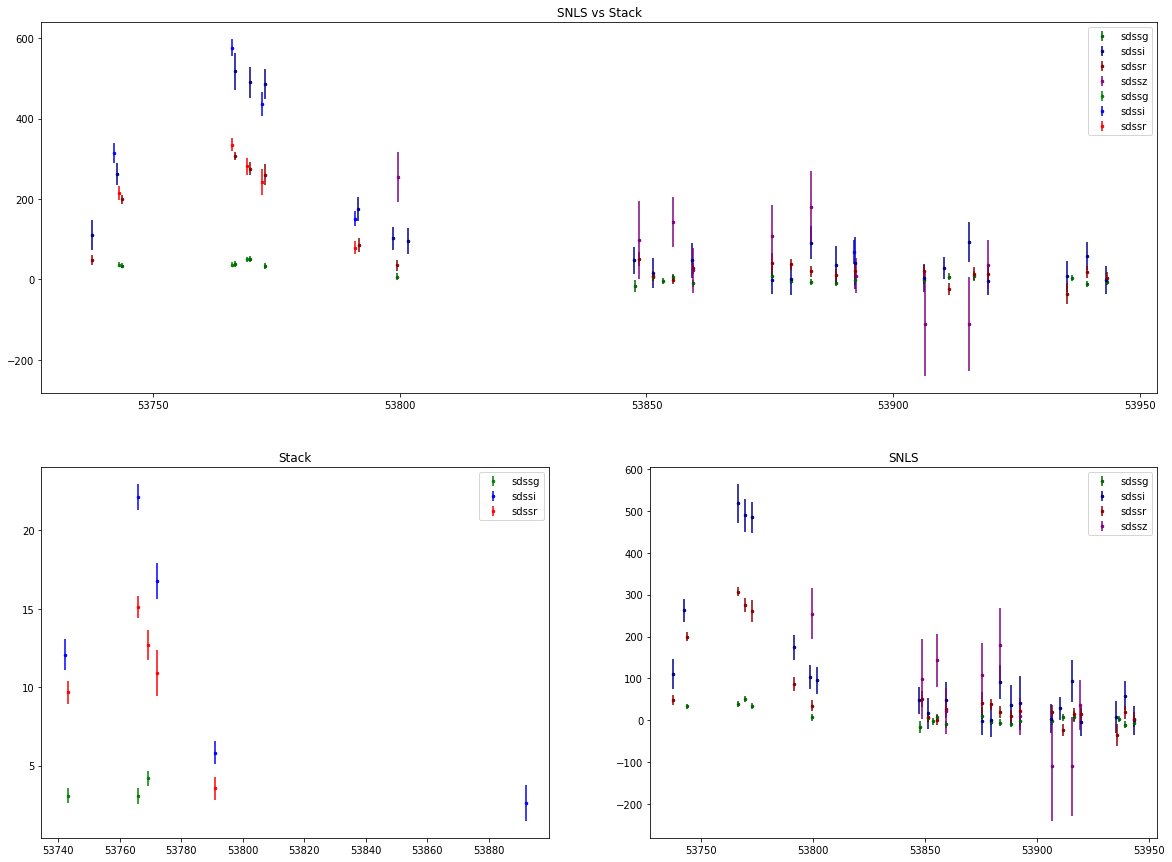

214.857611982 52.641034685
{'sdssi': 28.44796377368797, 'sdssr': 19.362834542104853, 'sdssz': 31.845326148748864, 'sdssg': 17.077039929779847}


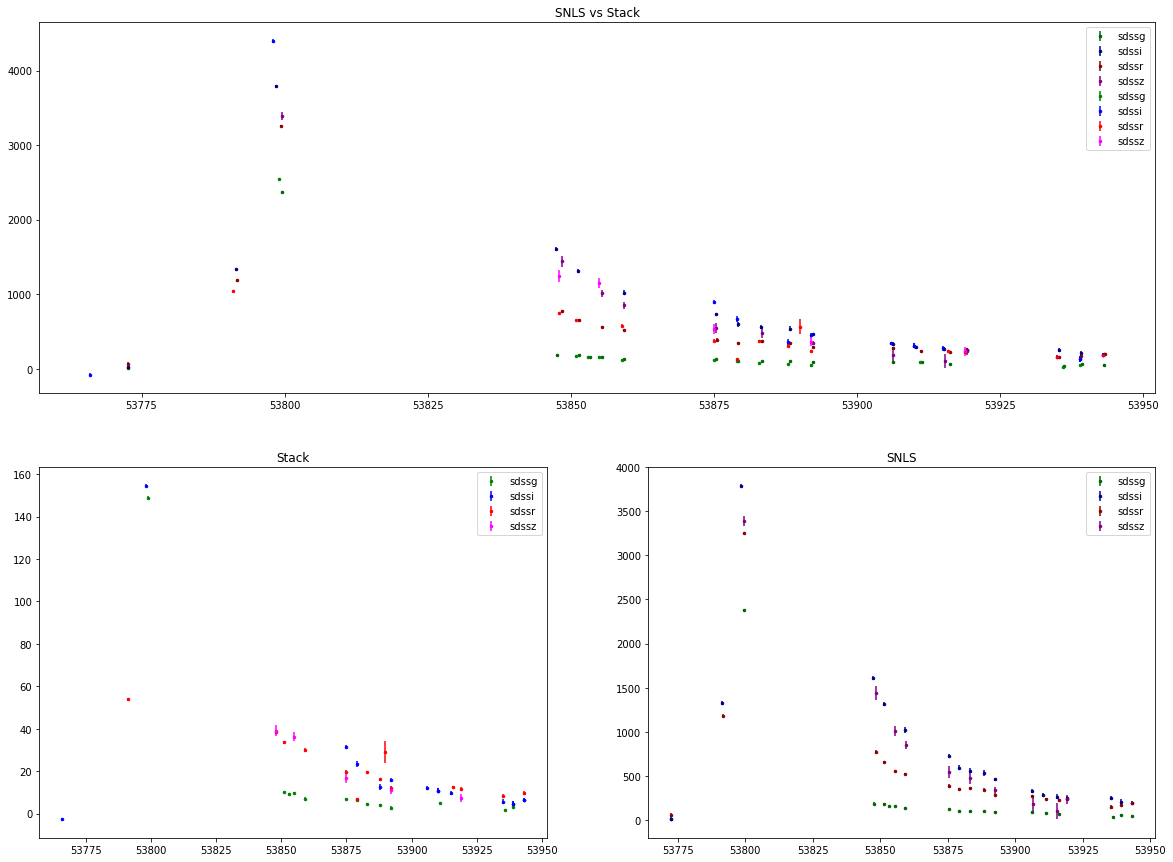

215.5719006 52.9576623713
{'sdssi': 17.534345389495648, 'sdssr': 23.965656033533222, 'sdssz': 21.404189440319627, 'sdssg': 16.962078417139377}


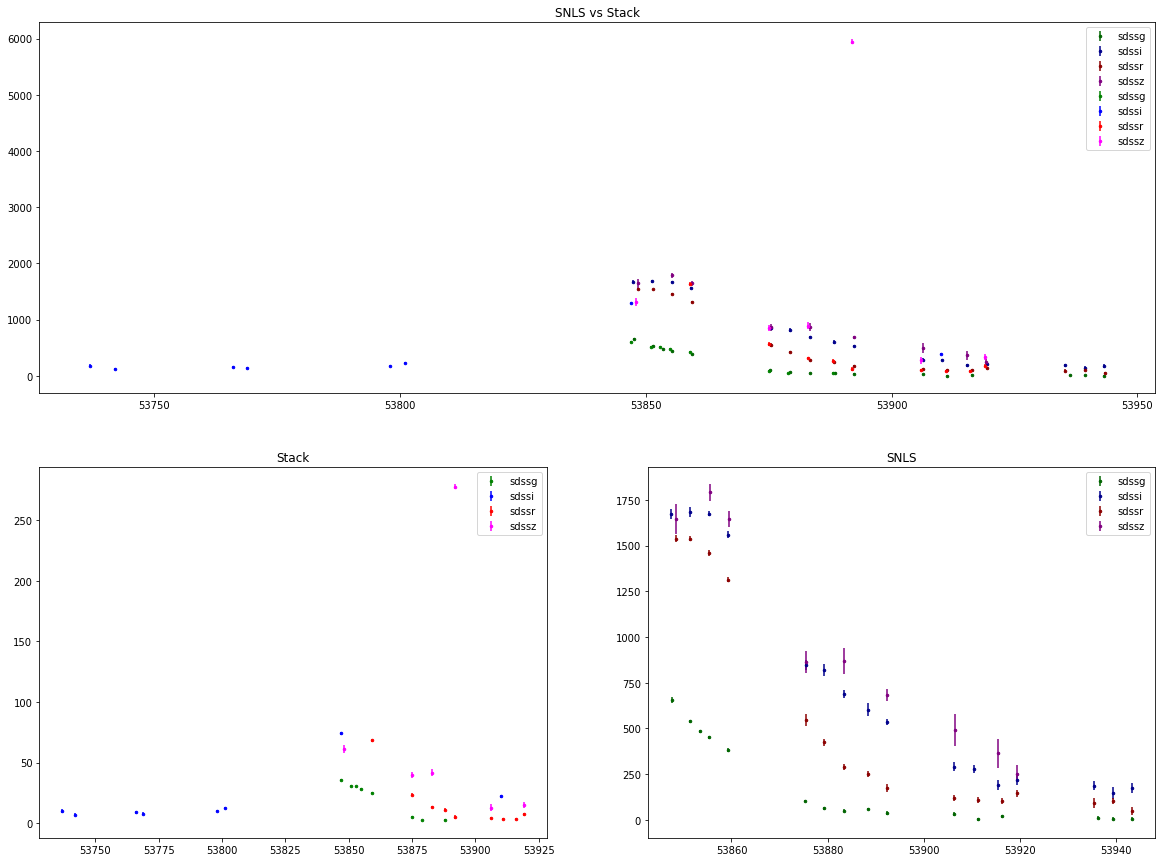

215.552319959 52.6408907839
{'sdssi': 22.612707068733663, 'sdssr': 20.60863643499885, 'sdssz': 26.656716049141306, 'sdssg': 16.596521692157356}


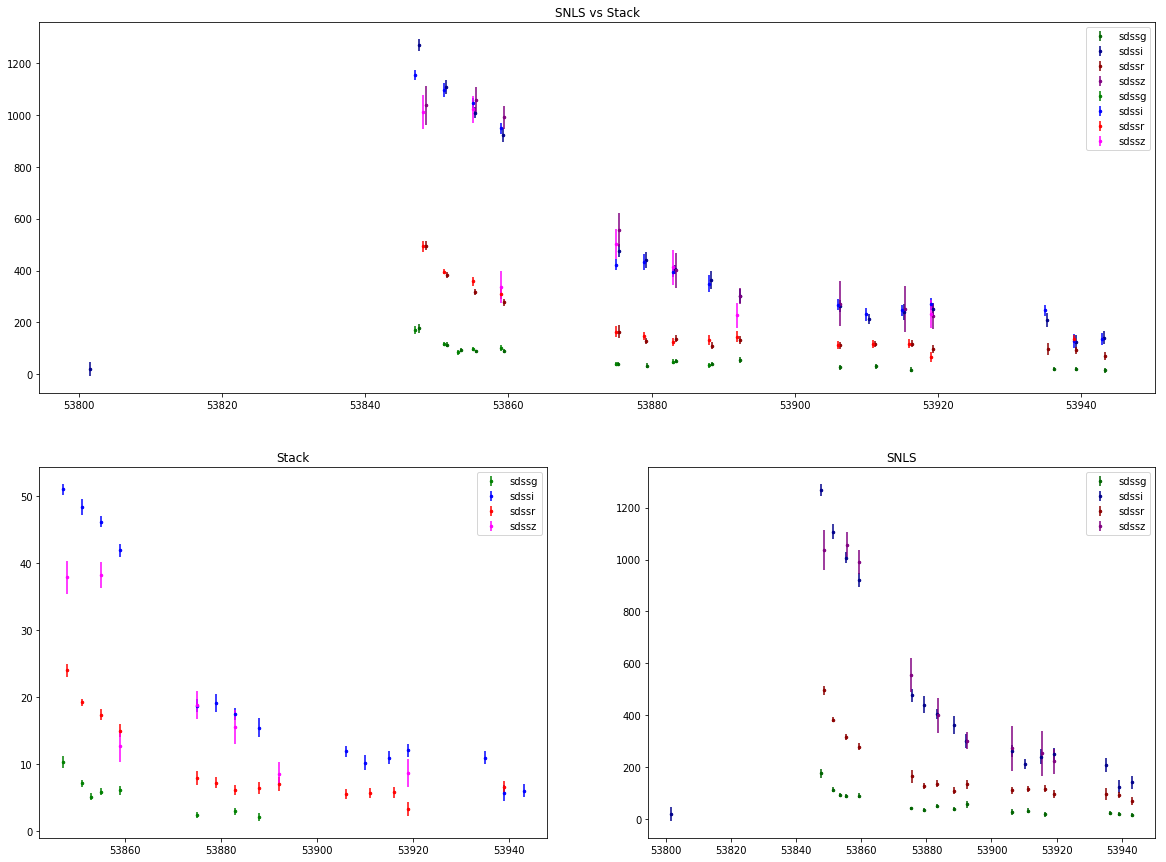

214.247547127 52.882489376
{'sdssi': 28.343102835613973, 'sdssr': 20.686819225596867, 'sdssz': 26.251308276226151, 'sdssg': 15.816326466962488}


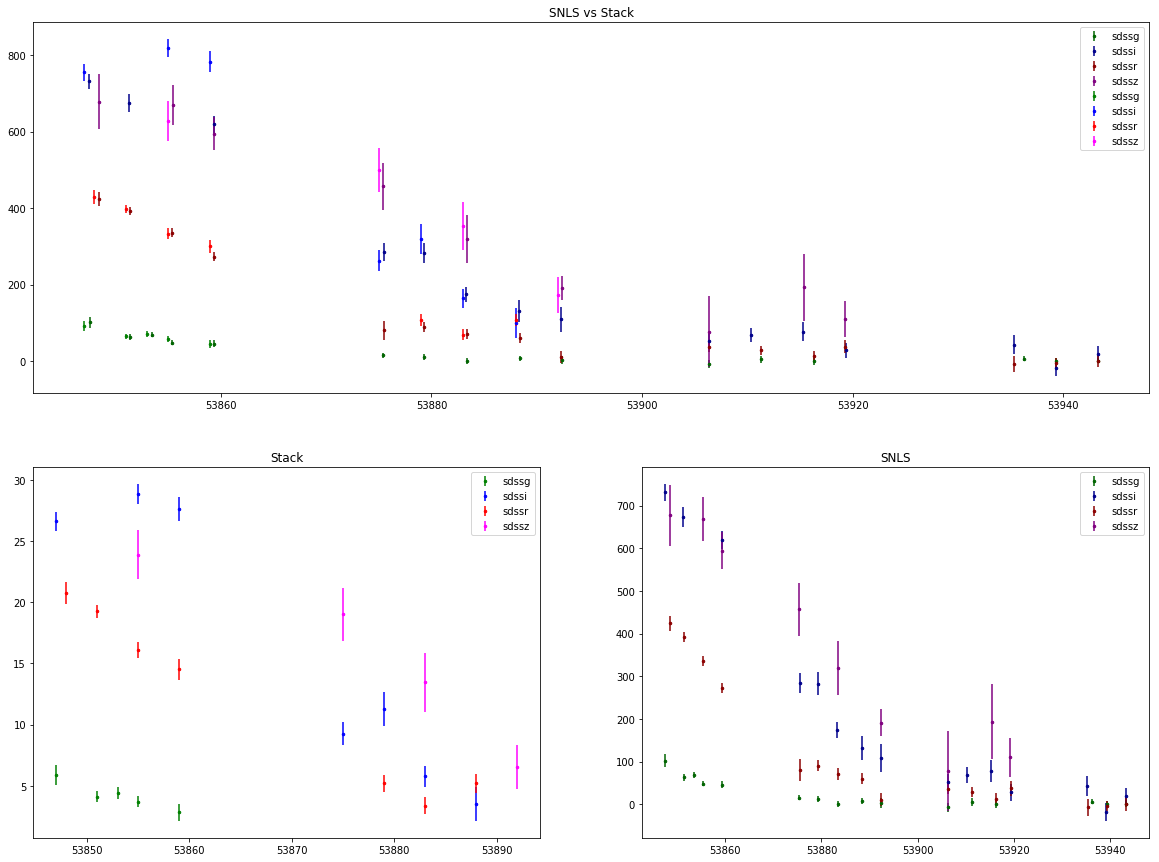

214.340182745 52.4528232366
{'sdssi': 24.276123067405226, 'sdssr': 18.676306582870779, 'sdssz': 24.048241376675392, 'sdssg': 15.927964338866211}


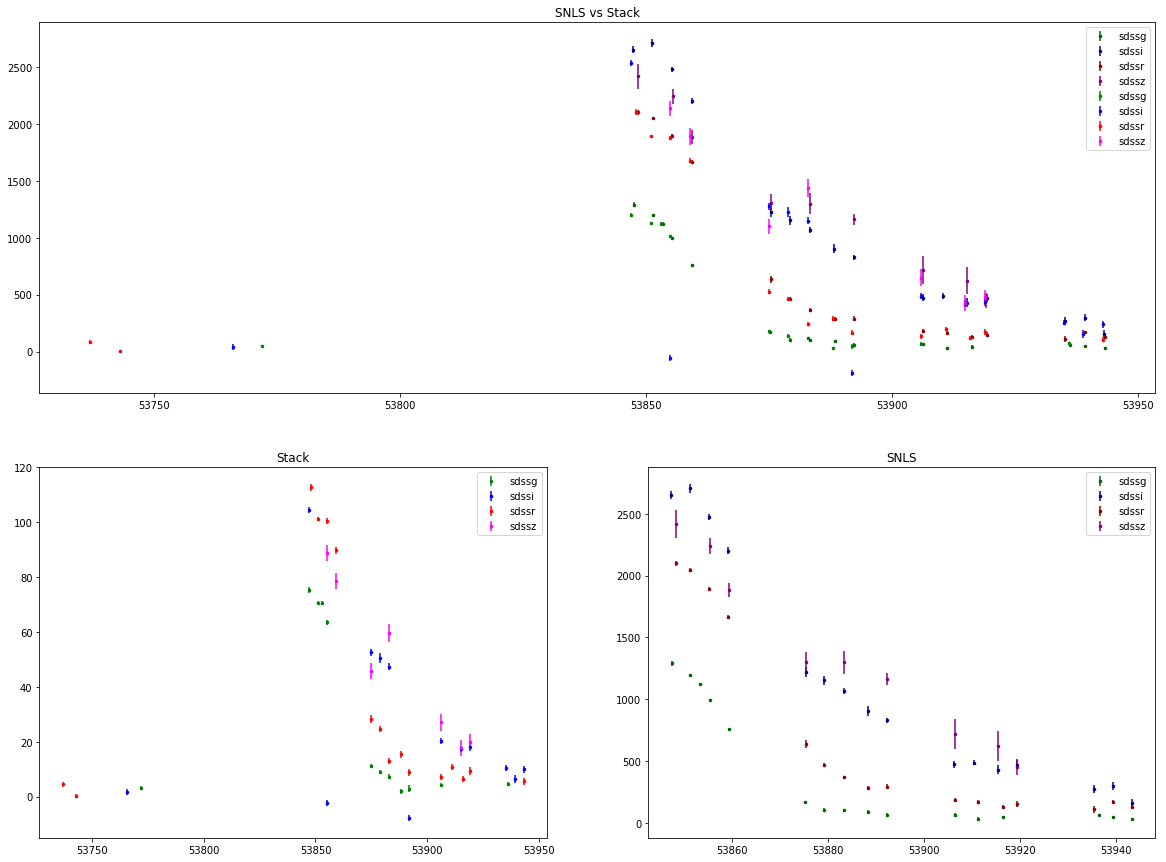

214.340223266 52.4527770349
{'sdssi': 24.276123067405226, 'sdssr': nan, 'sdssz': 24.048241376675392, 'sdssg': 12.351566651935068}


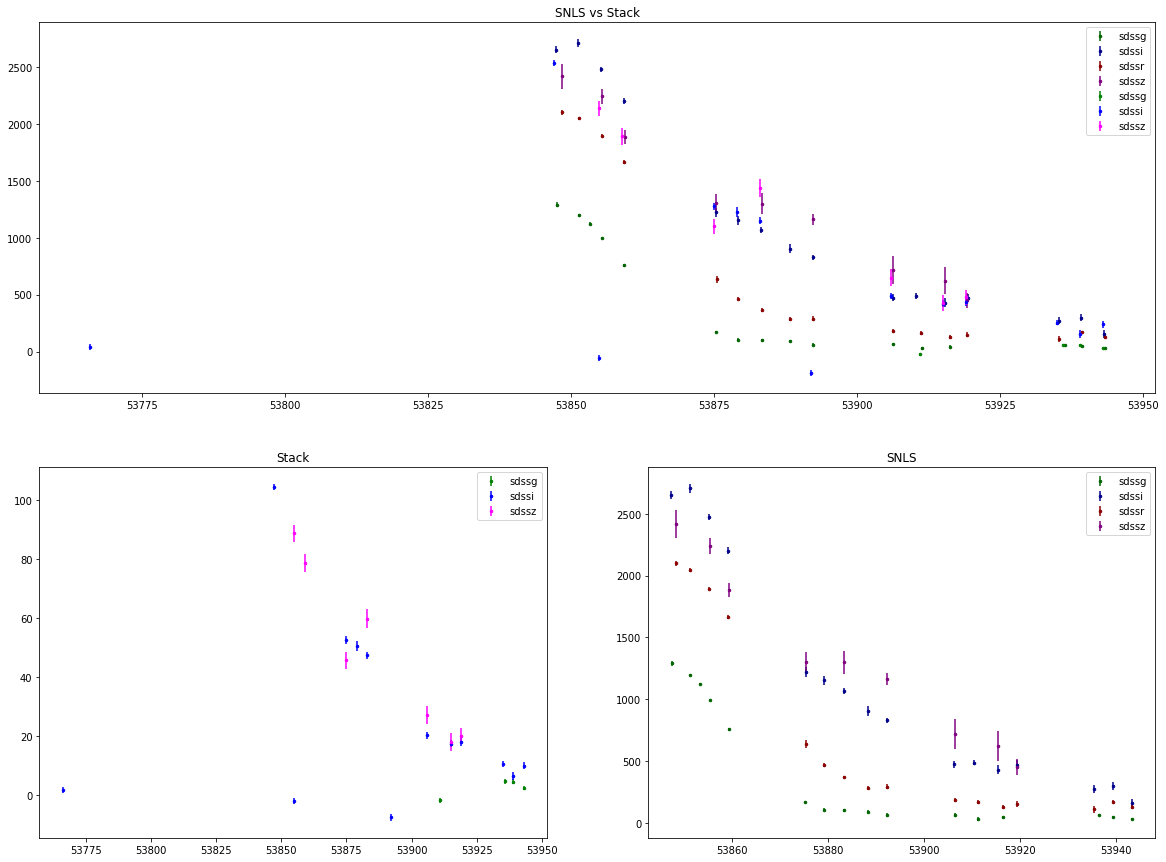

214.699260622 52.7565103978
{'sdssi': 22.555999531729469, 'sdssr': 19.492777518926584, 'sdssz': 25.293246253786105, 'sdssg': 15.046693713054104}


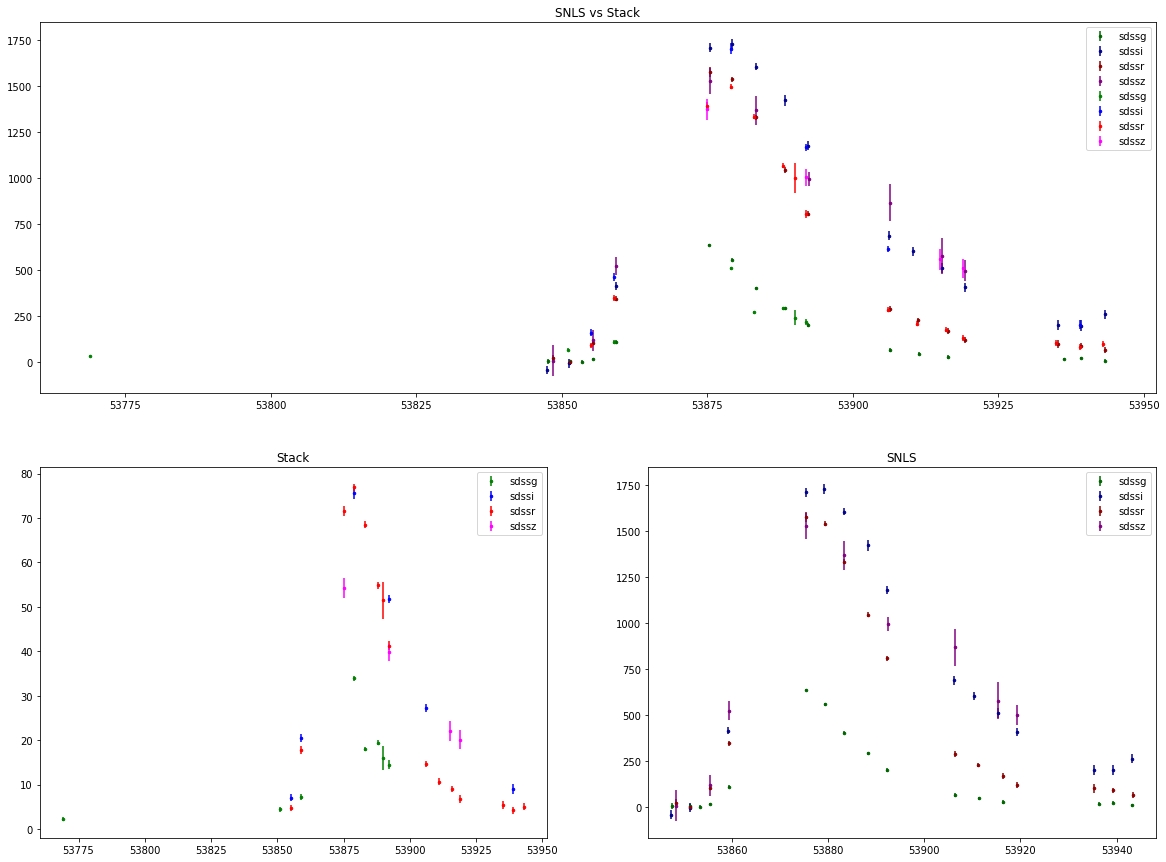

214.254445297 52.2324420075
{'sdssi': 22.407589230951416, 'sdssr': 18.331229693559369, 'sdssz': 24.539697319191134, 'sdssg': 15.865997492135572}


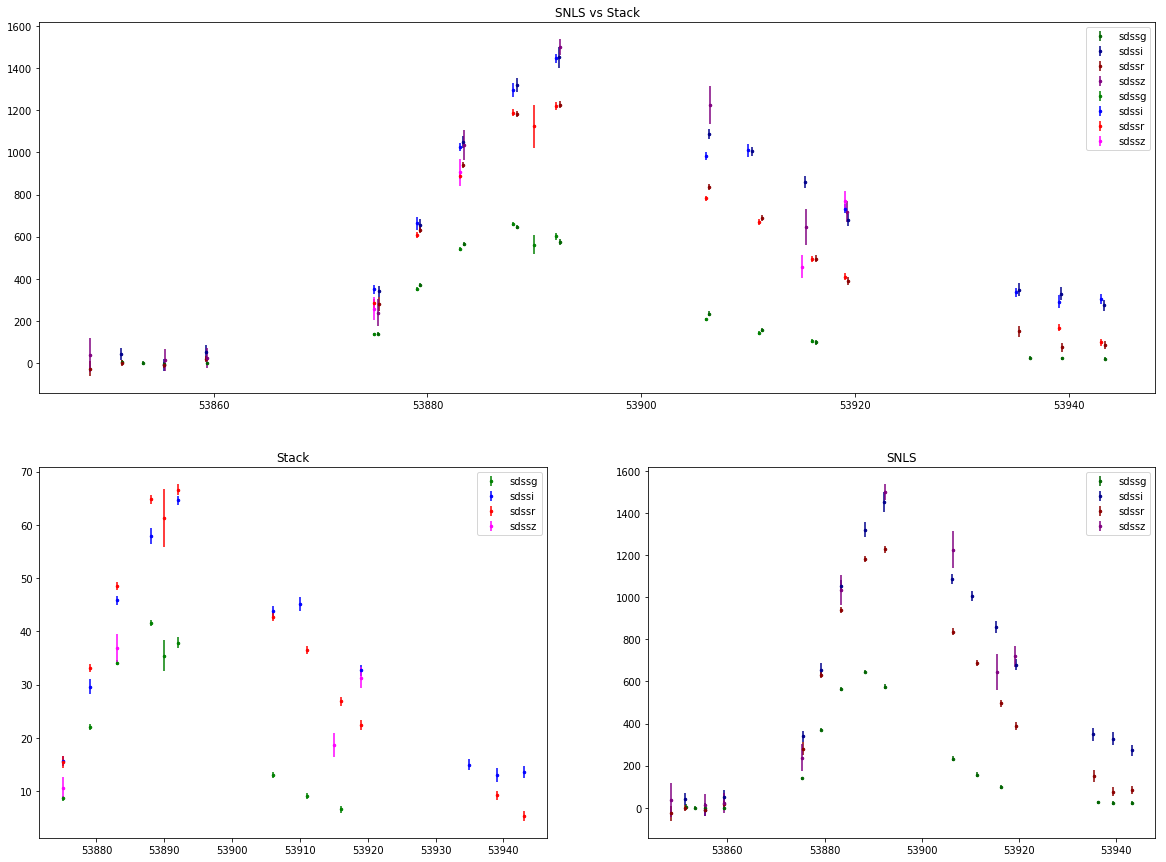

214.254289197 52.2324407914
{'sdssi': nan, 'sdssr': nan, 'sdssz': nan, 'sdssg': nan}


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/scipy/stats/stats.py:2648: RuntimeWarning: invalid value encountered in greater
  c = c[(c > critlower) & (c < critupper)]
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/scipy/stats/stats.py:2648: RuntimeWarning: invalid value encountered in less
  c = c[(c > critlower) & (c < critupper)]


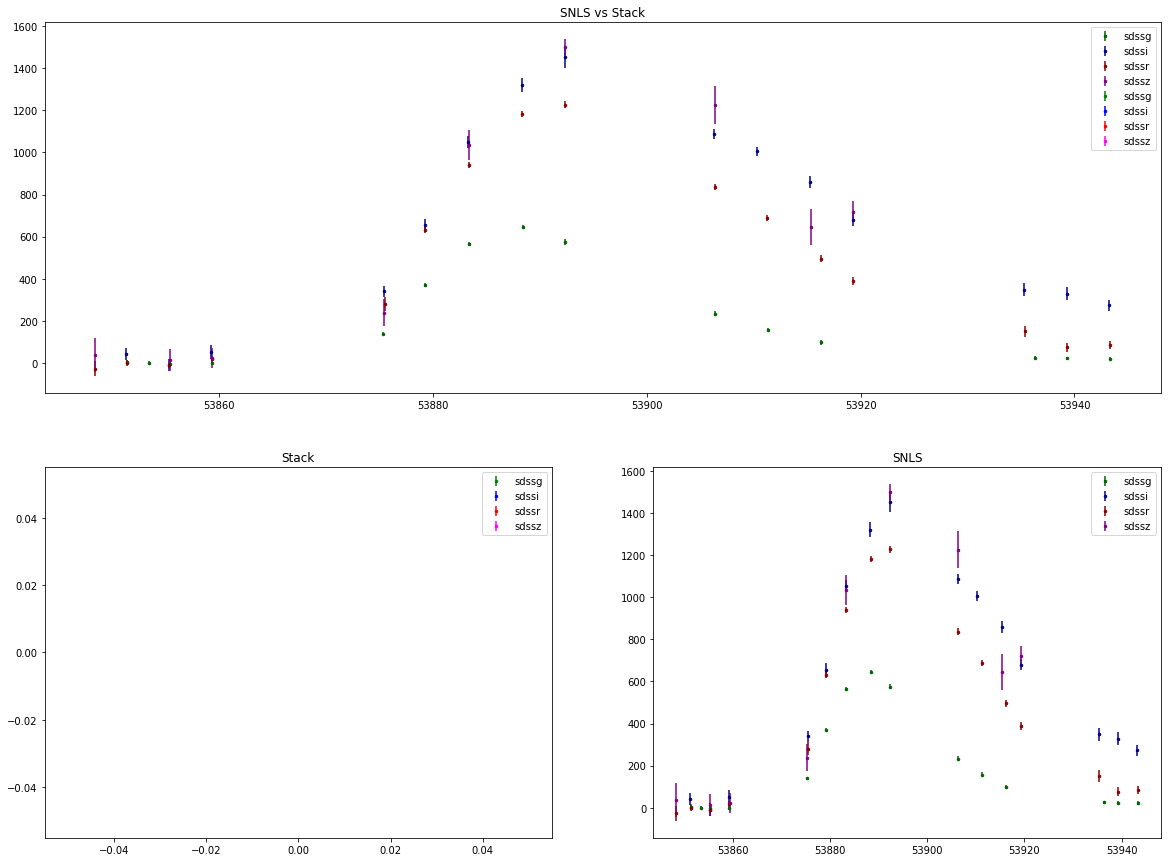

214.847679703 53.0229650379
{'sdssi': 22.847215919228073, 'sdssr': 19.625765391855502, 'sdssz': 27.022781691346101, 'sdssg': nan}


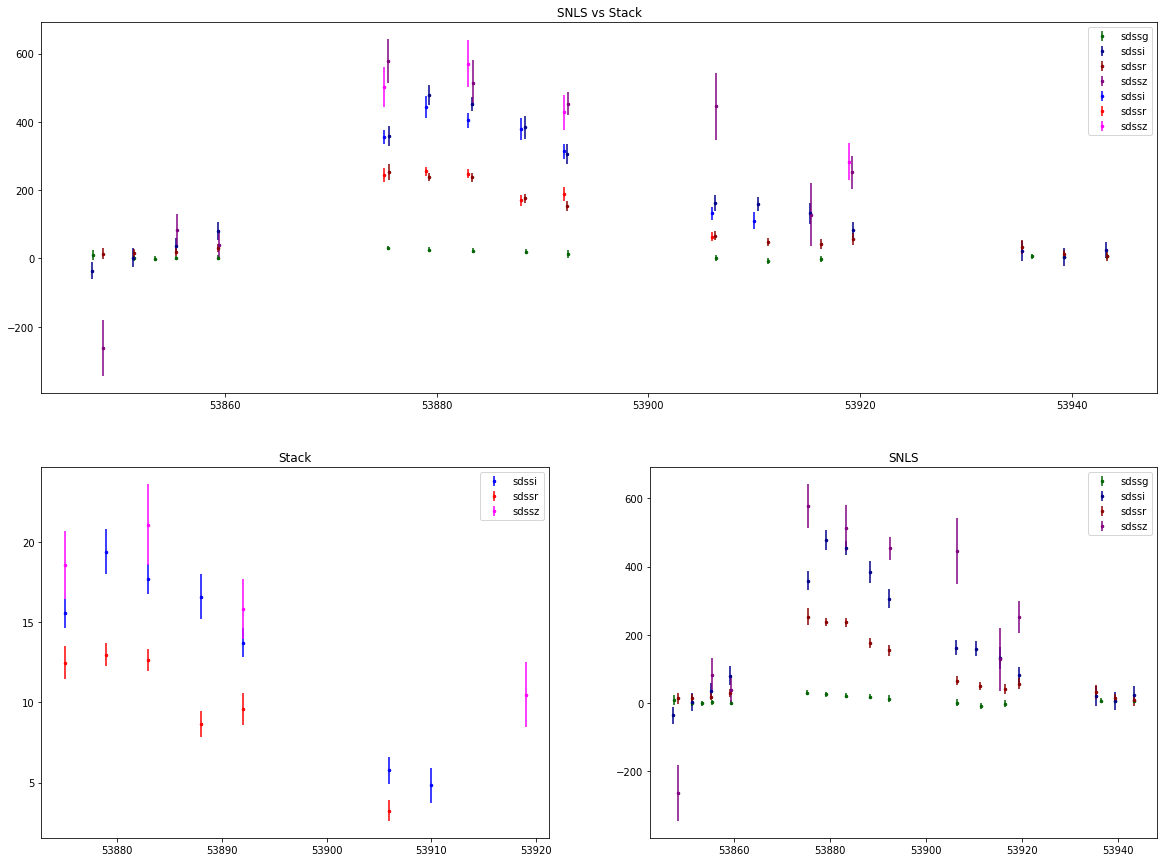

215.30553856 52.4561087597
{'sdssi': 21.796696761333024, 'sdssr': 18.555811447226191, 'sdssz': 27.694825464568069, 'sdssg': nan}


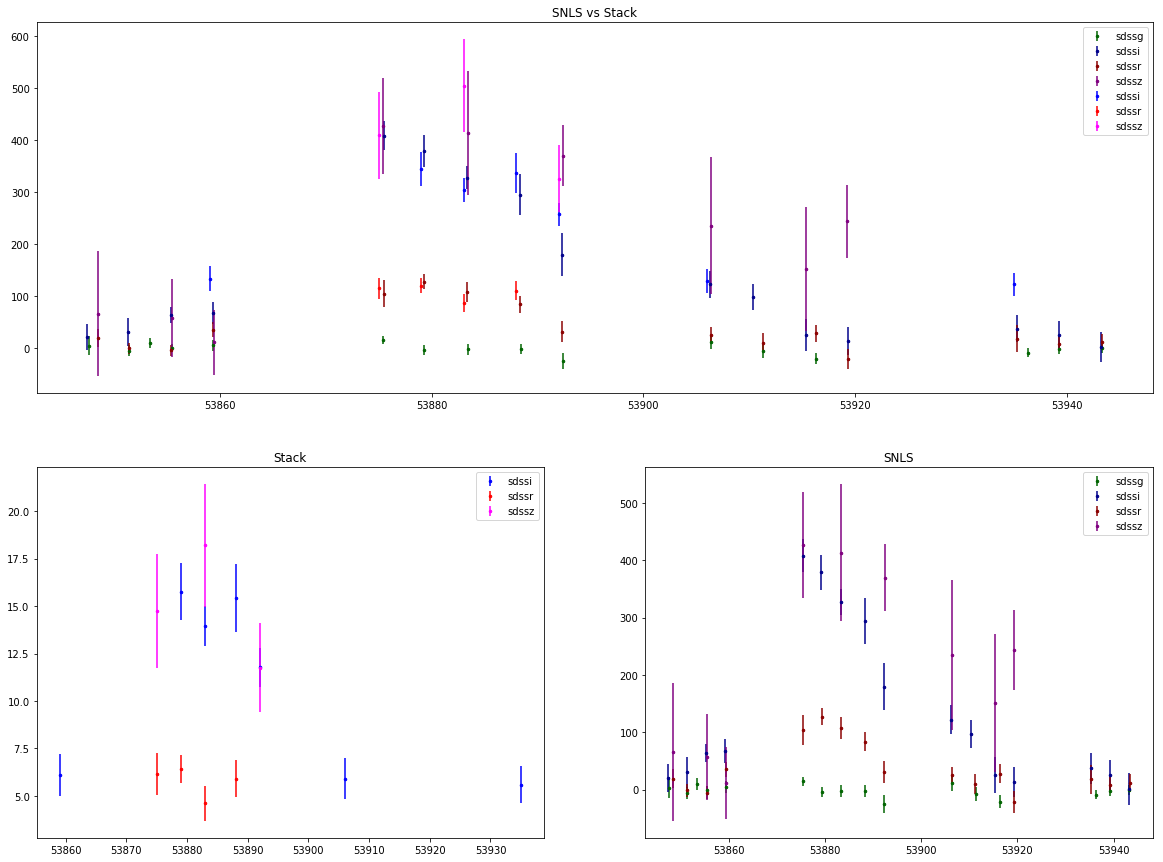

215.519738372 52.3384309244
{'sdssi': 23.77190925395, 'sdssr': 18.722437811922912, 'sdssz': 27.08695743718167, 'sdssg': 17.627465149413688}


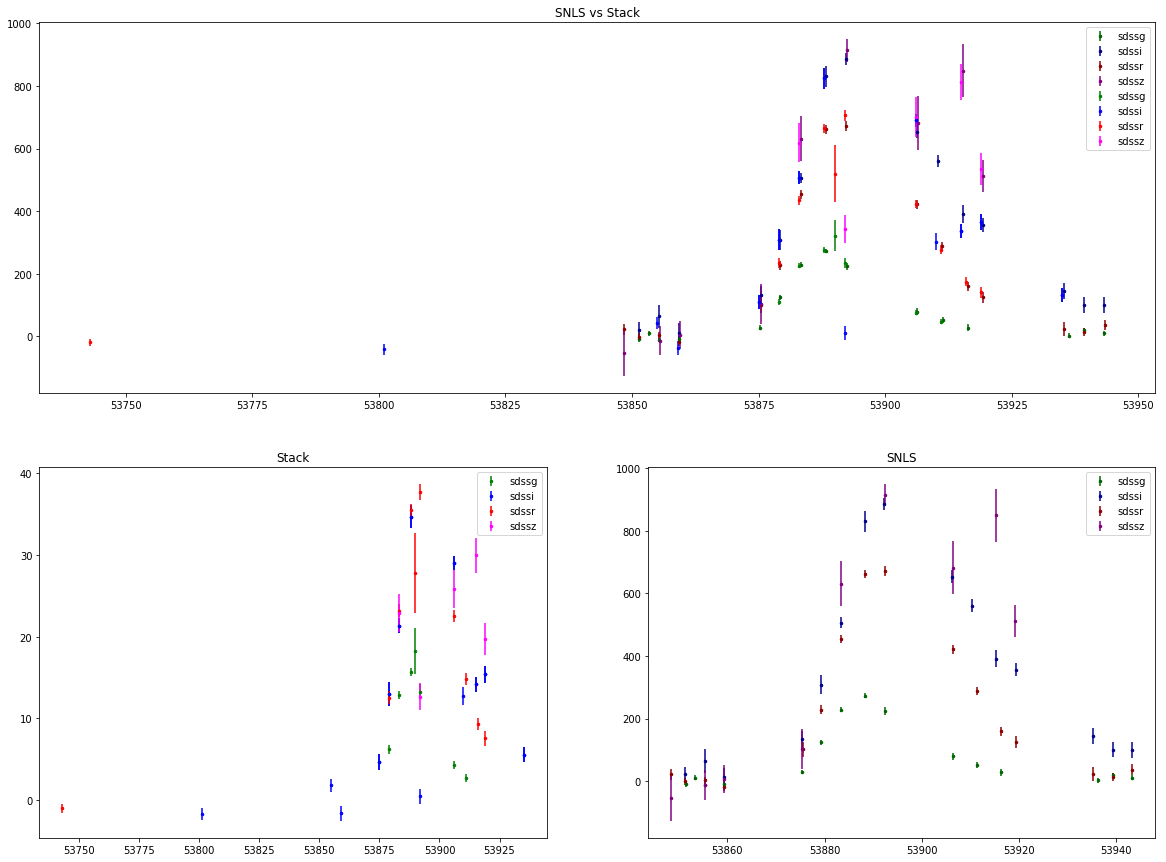

215.519711974 52.3384208
{'sdssi': 23.77190925395, 'sdssr': nan, 'sdssz': 27.08695743718167, 'sdssg': nan}


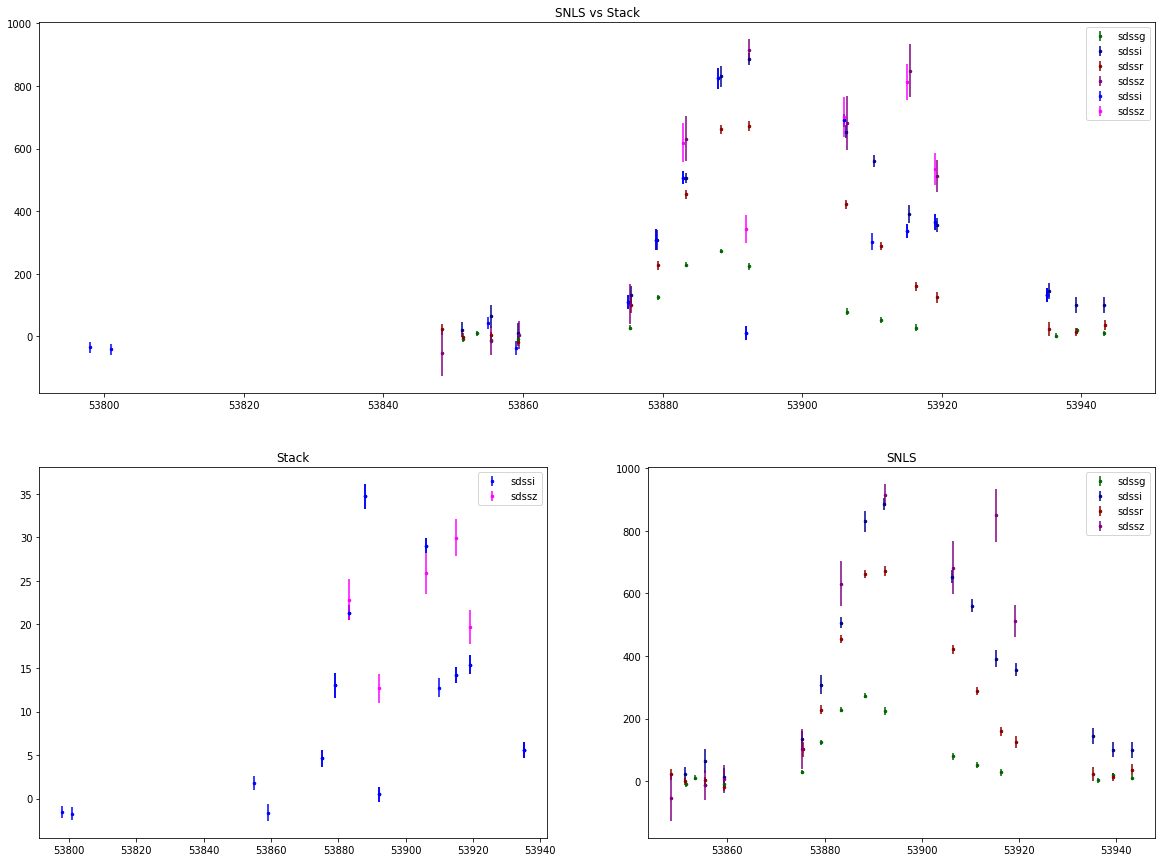

215.077580269 52.8971042888
{'sdssi': 25.190230201174785, 'sdssr': 19.01584354825285, 'sdssz': 25.928291420863317, 'sdssg': 15.591230316308057}


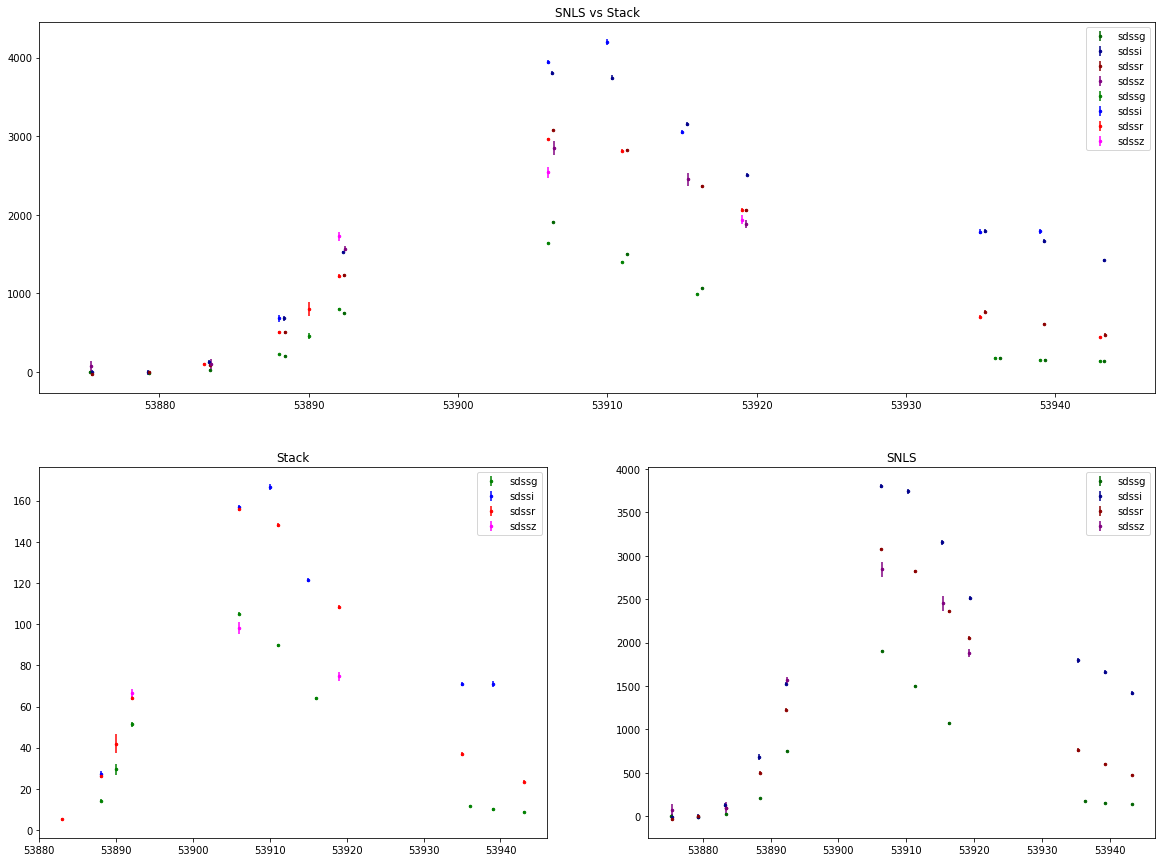

214.630804728 52.4429738166
{'sdssi': 24.869363027446582, 'sdssr': 20.329600768751057, 'sdssz': nan, 'sdssg': nan}


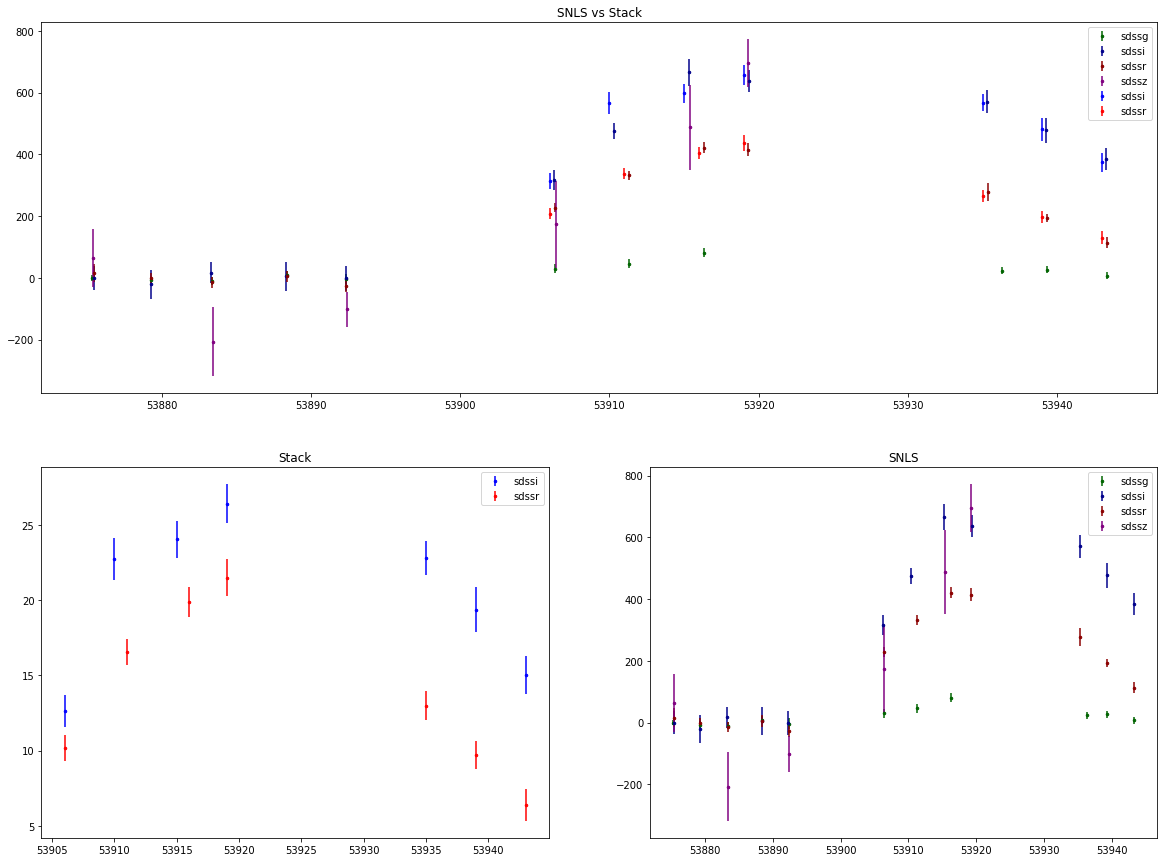

214.436026194 52.361379816
{'sdssi': 21.693656279676116, 'sdssr': nan, 'sdssz': 25.731164270660315, 'sdssg': nan}


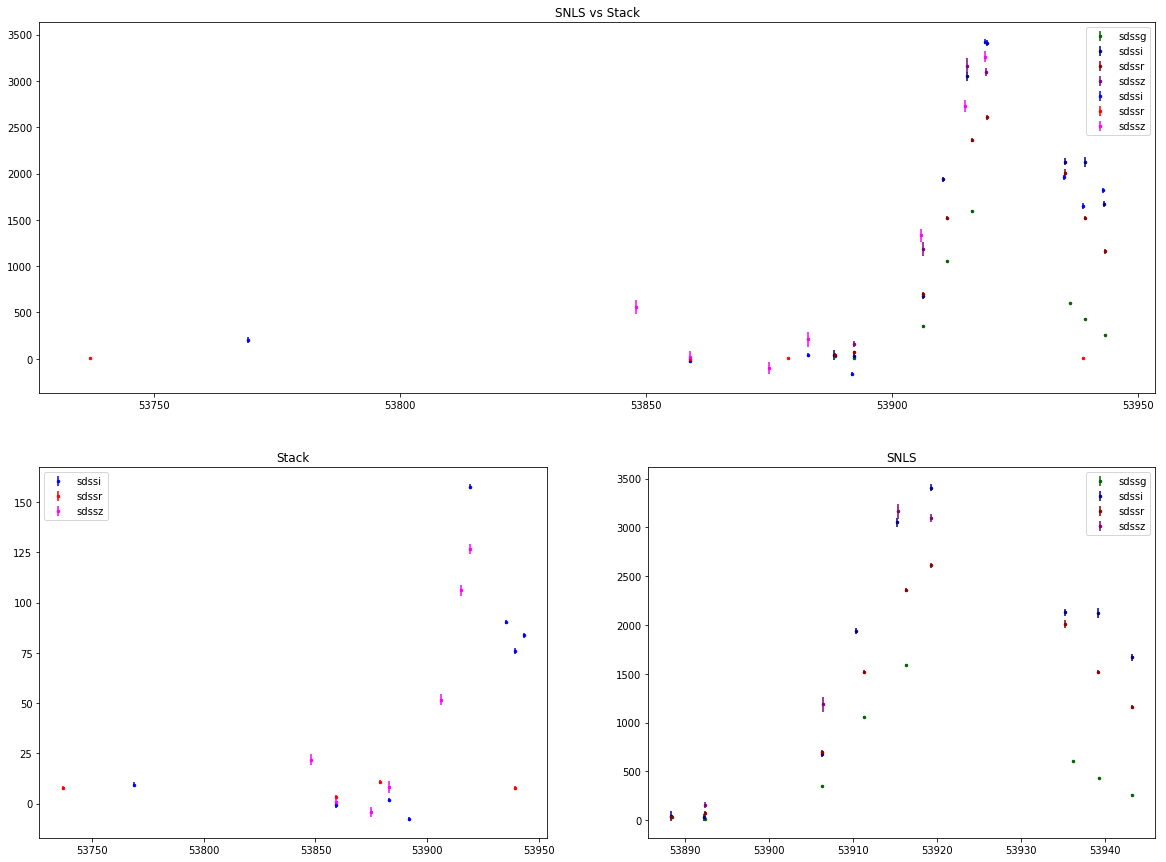

214.435799711 52.3612559675
{'sdssi': 21.693656279676116, 'sdssr': 19.845788173055116, 'sdssz': 25.731164270660315, 'sdssg': 16.633601840610229}


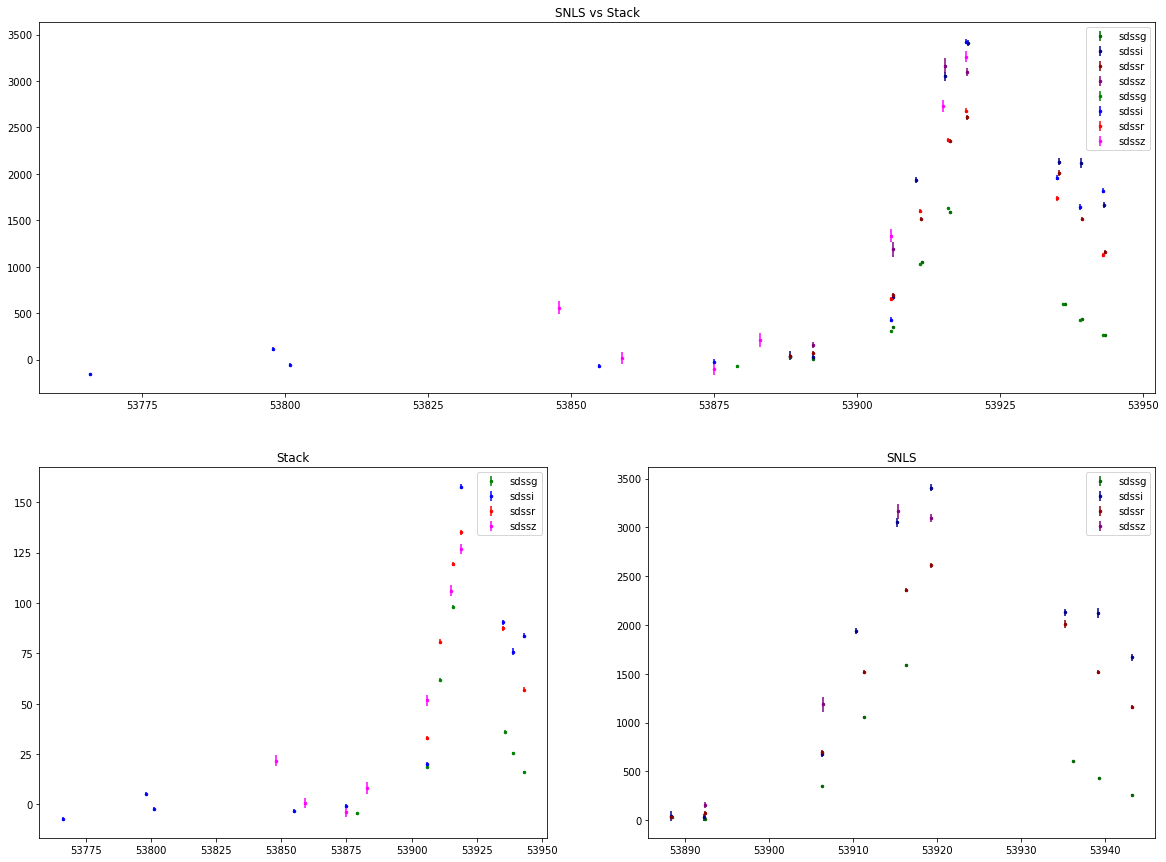

214.263527612 52.9361907548
{'sdssi': 24.569695438662709, 'sdssr': 20.839371929249801, 'sdssz': nan, 'sdssg': 17.461076397772622}


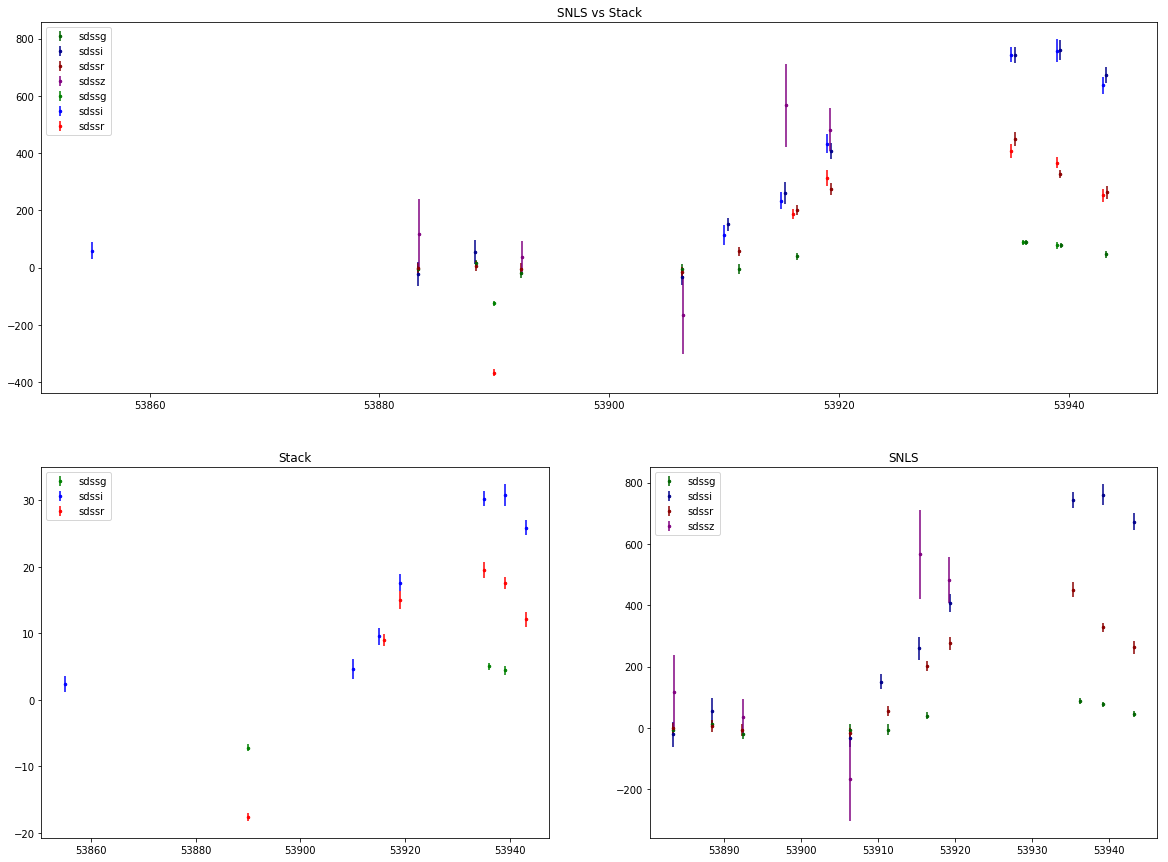

In [9]:
for match in matches_45:
    t = match[-1]
    

    plt.figure(figsize=(20,15))
    c = coord.SkyCoord(ra=float(np.mean(t['ra'])), dec=float(np.mean(t['dec'])), unit=(u.rad))
    print c.ra.deg, c.dec.deg
    
    plt.subplot2grid((2, 2), (0, 0), colspan=2)
    
    n_factors = {}
    n_factors["sdssi"]=normalize_light_curve( match[0],t, "sdssi")
    n_factors["sdssg"]=normalize_light_curve( match[0],t, "sdssg")
    n_factors["sdssr"]=normalize_light_curve( match[0],t, "sdssr")
    n_factors["sdssz"]=normalize_light_curve( match[0],t, "sdssz")
    
    print n_factors
    
    plt.title("SNLS vs Stack")
    show_multi_filter_light_curve(match[0], snls_colors)
    show_multi_filter_light_curve(t, stack_colors, n_factors)
    
    plt.subplot2grid((2, 2), (1, 0))
    plt.title("Stack")
    show_multi_filter_light_curve(t, stack_colors)
    
    plt.subplot2grid((2, 2), (1, 1))
    plt.title("SNLS")
    show_multi_filter_light_curve(match[0], snls_colors)
    plt.show()
    
   

This is the per filter visualization

-----------------


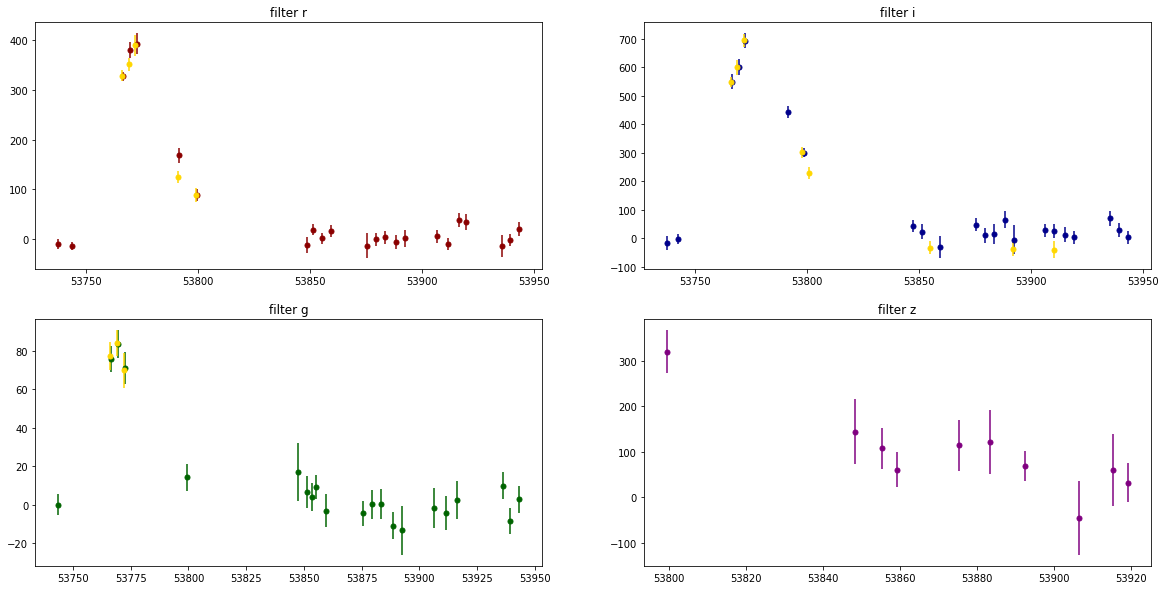

-----------------


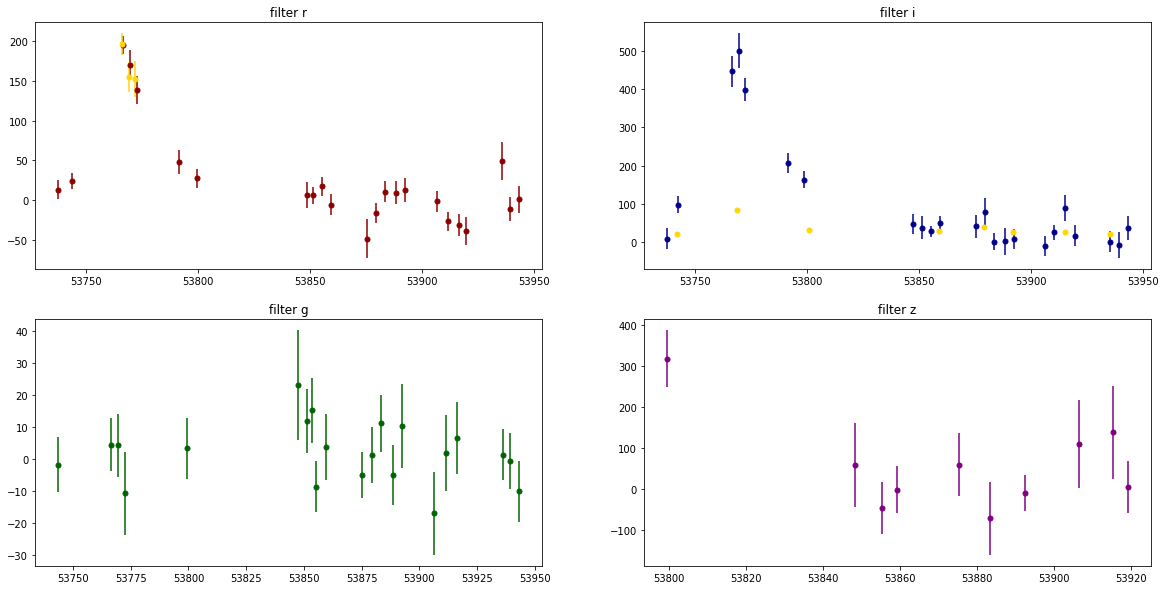

-----------------


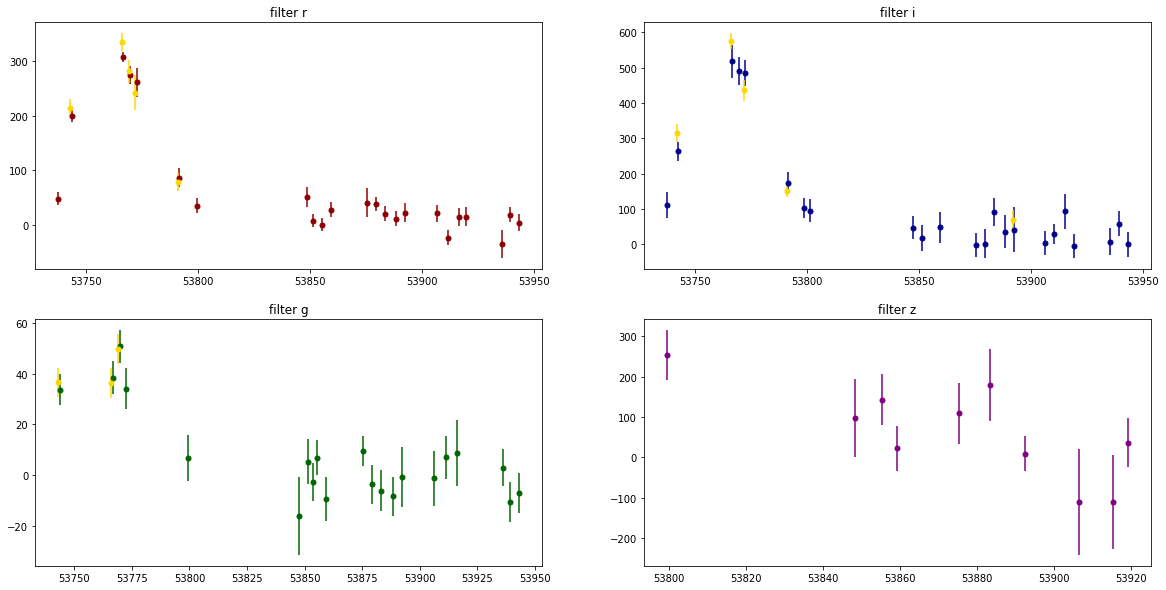

-----------------


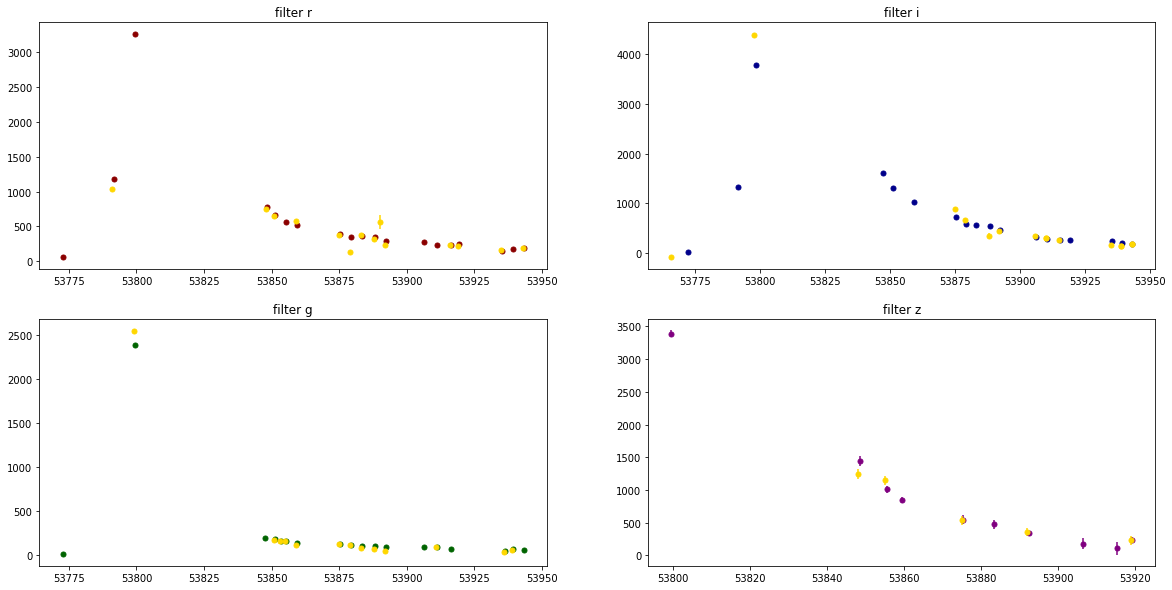

-----------------


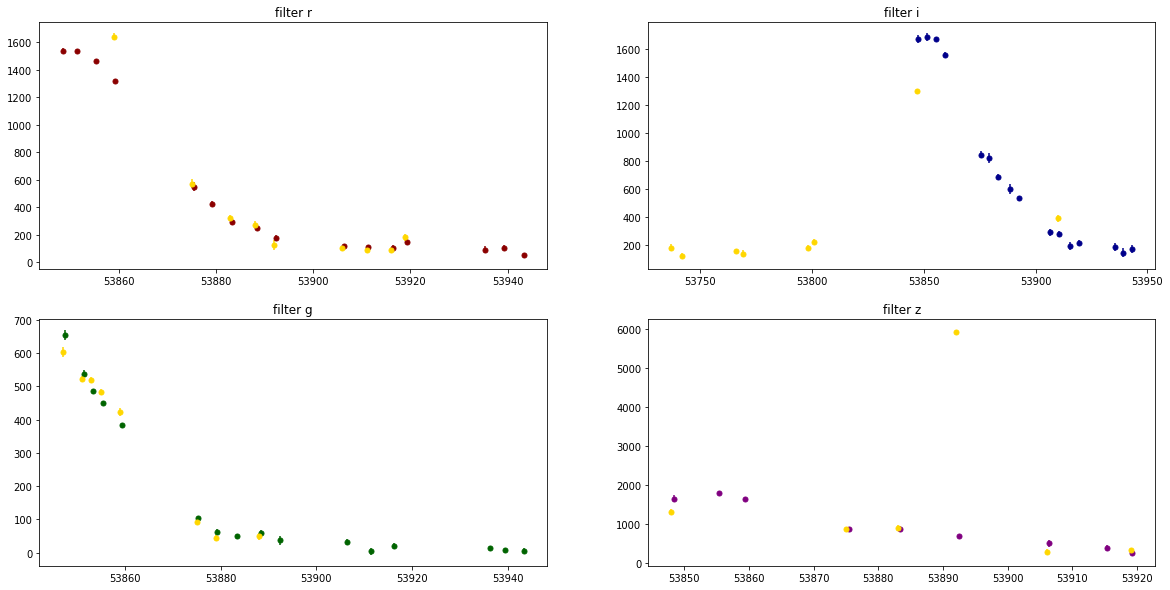

-----------------


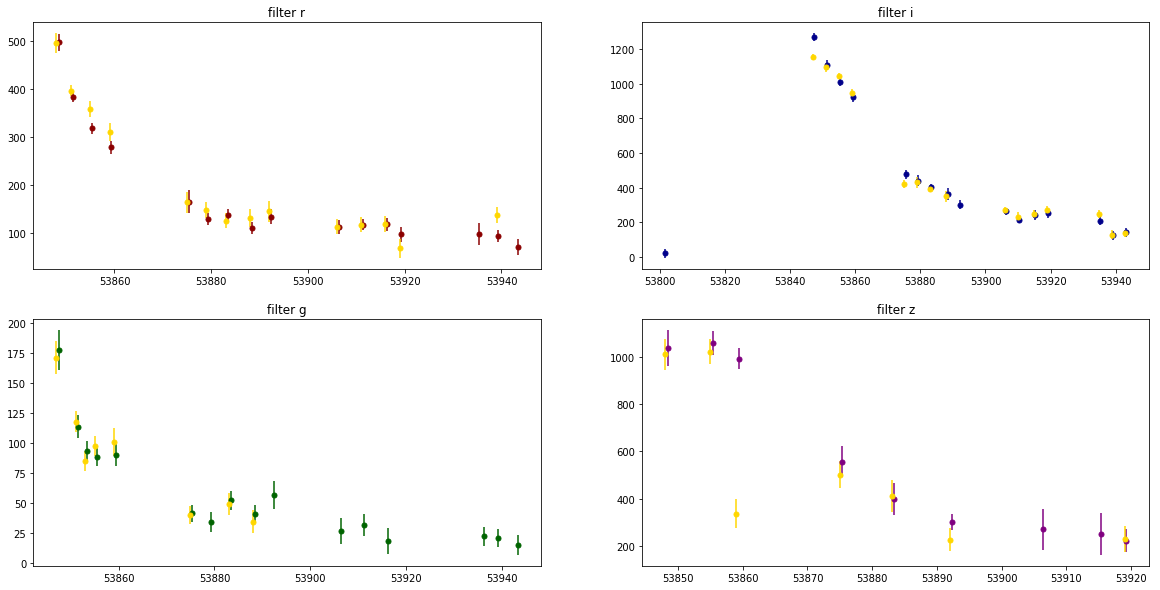

-----------------


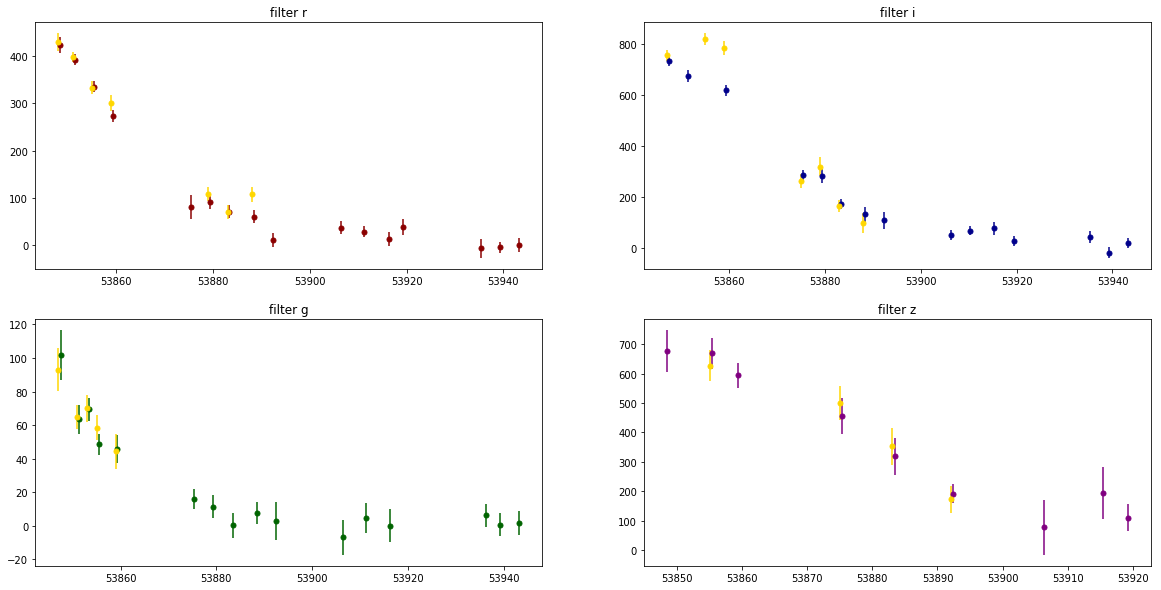

-----------------


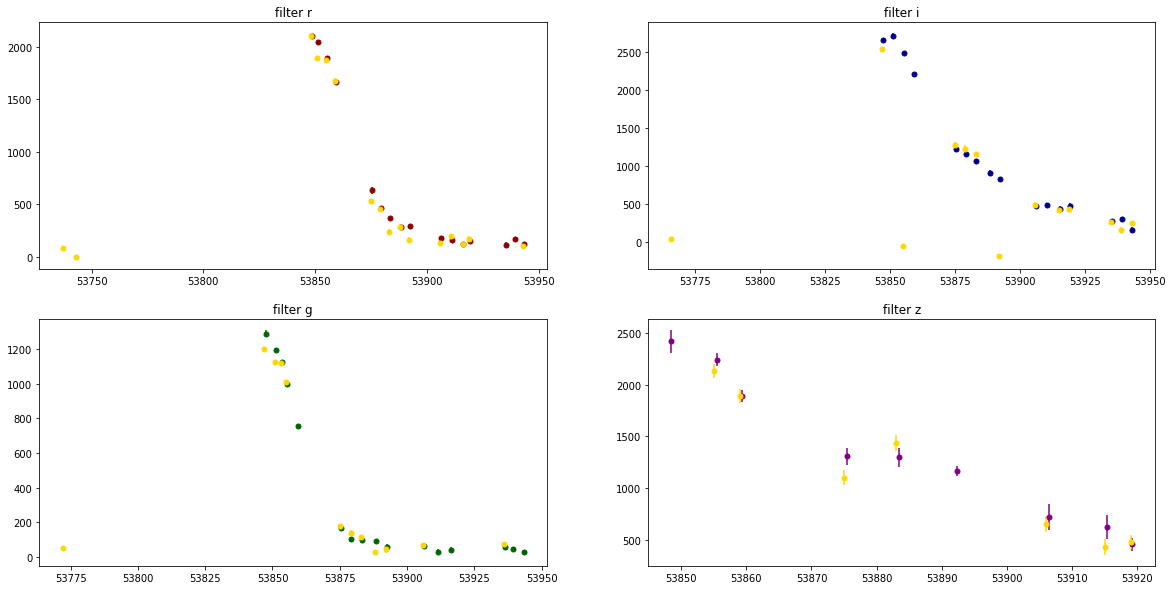

-----------------


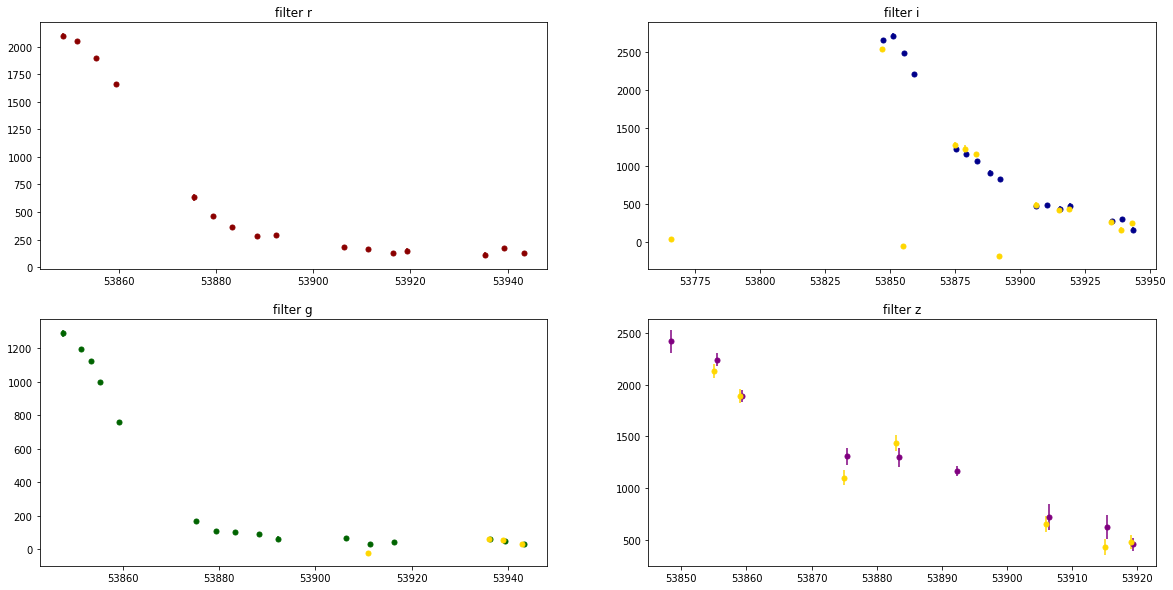

-----------------


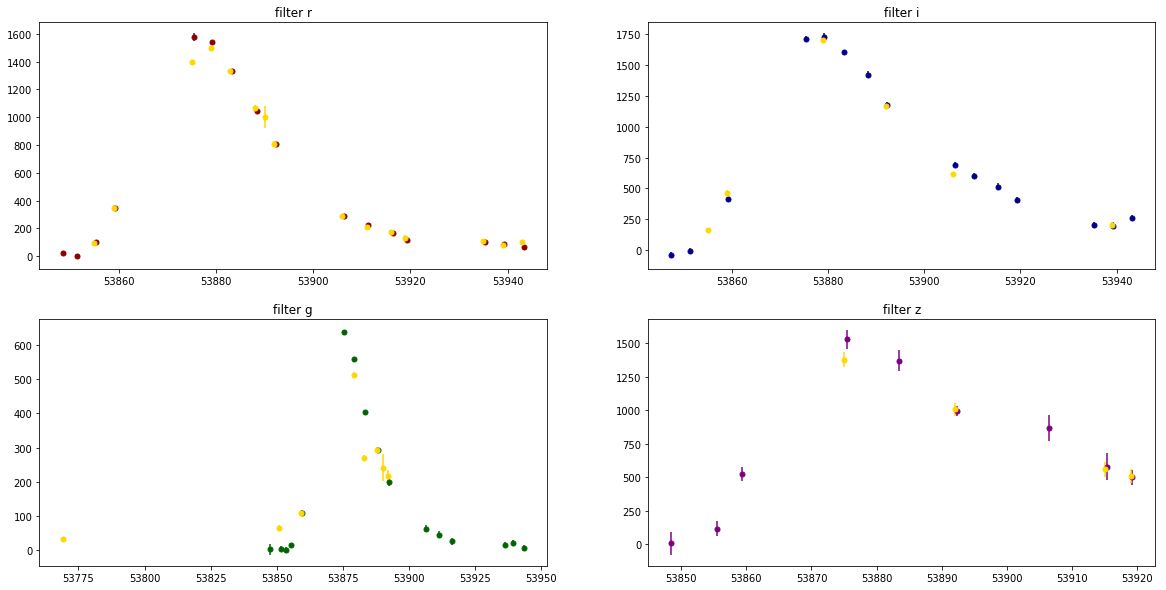

-----------------


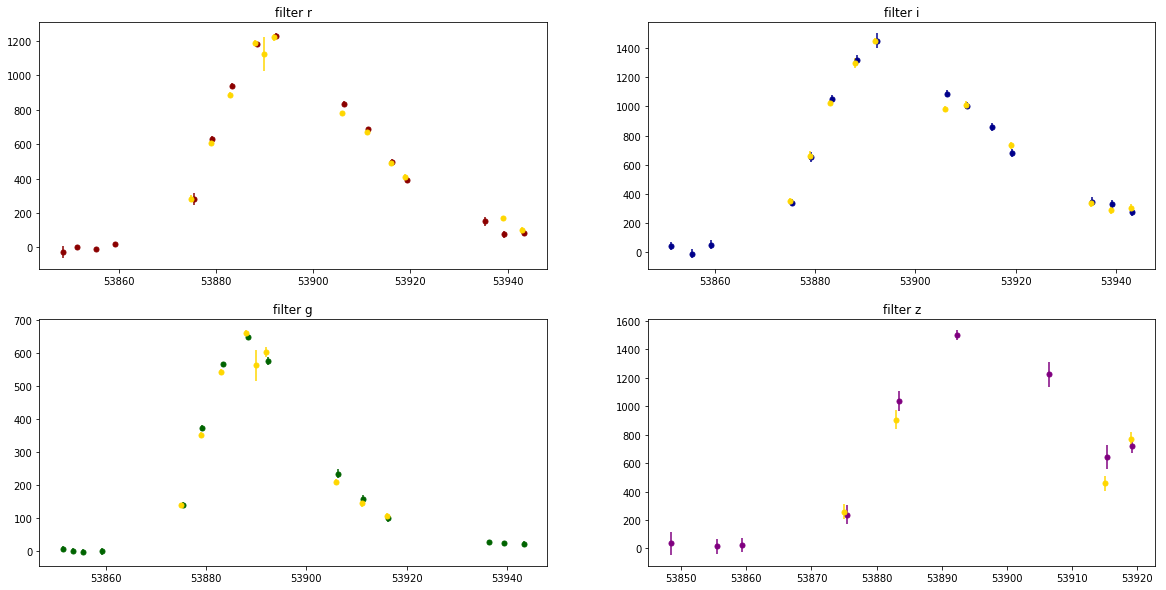

-----------------


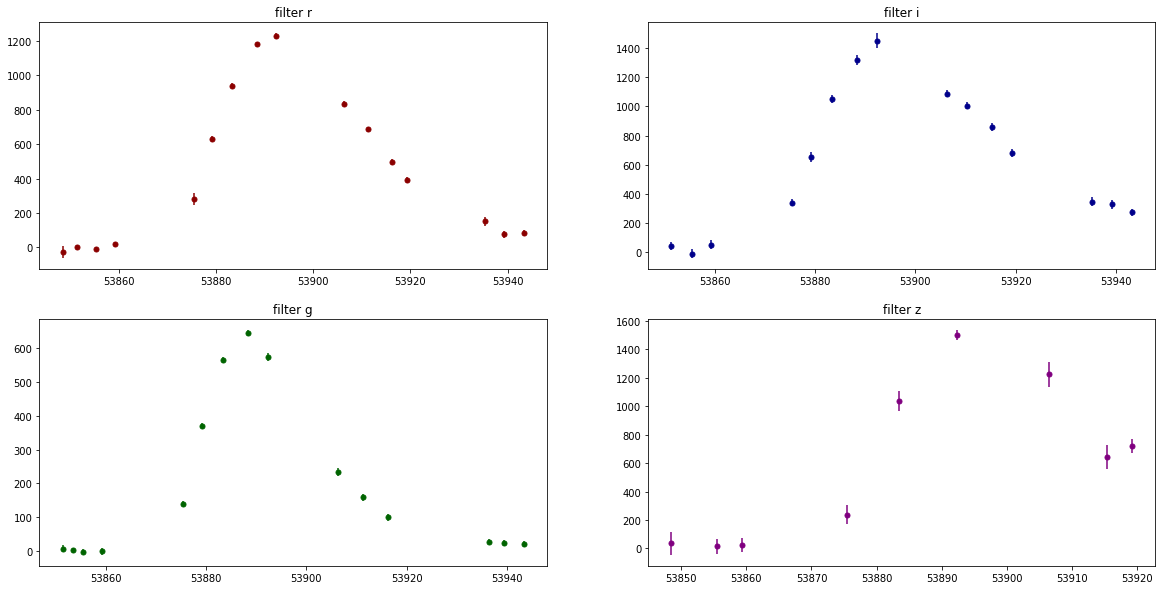

-----------------


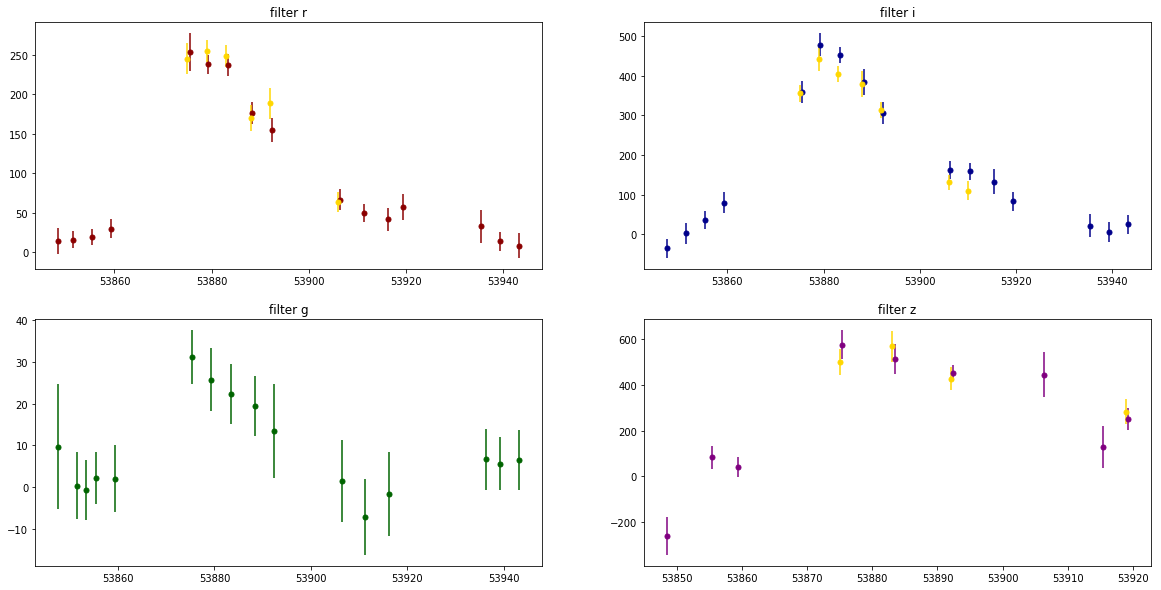

-----------------


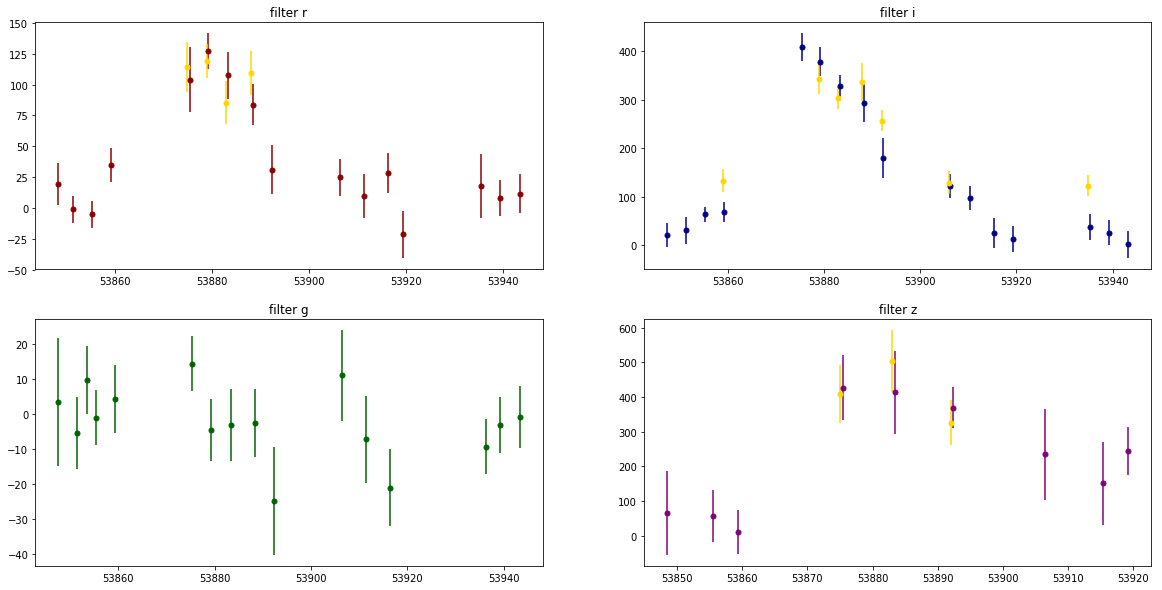

-----------------


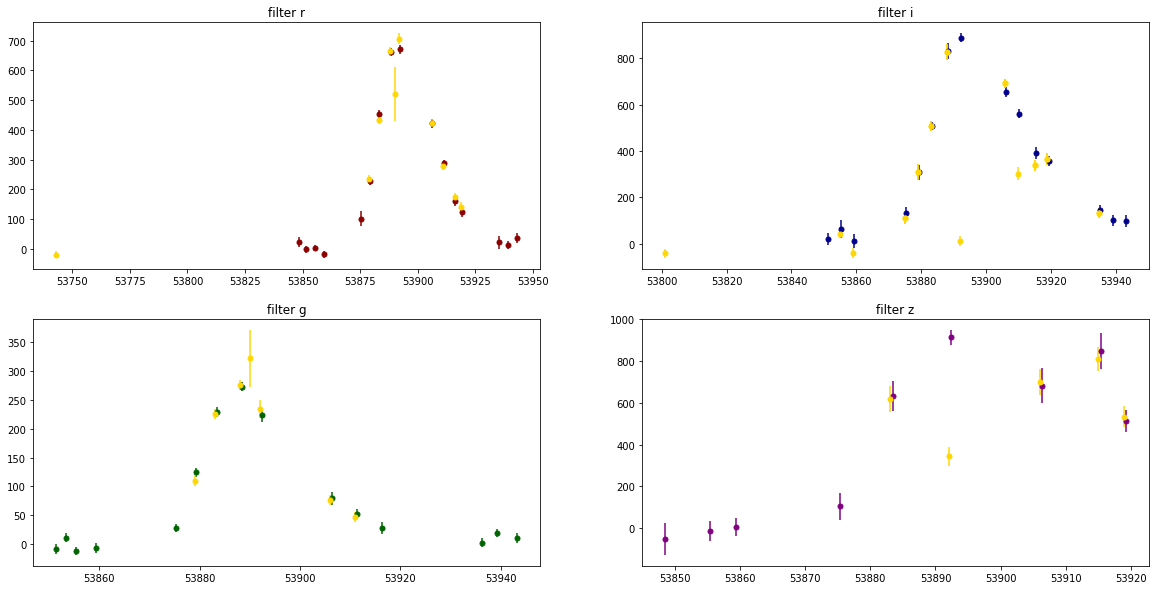

-----------------


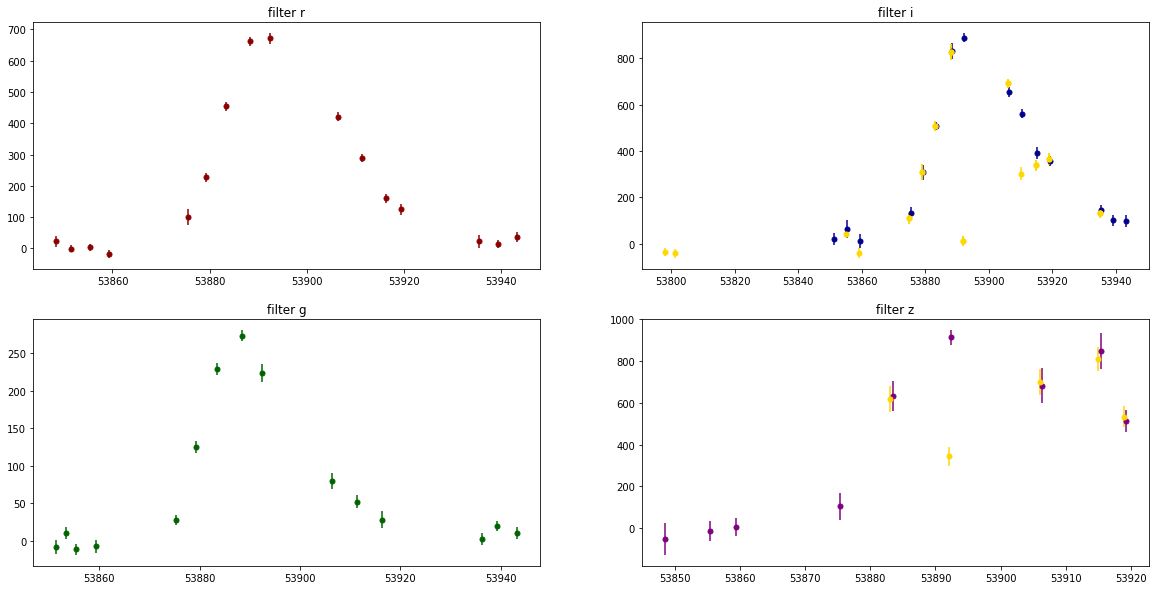

-----------------


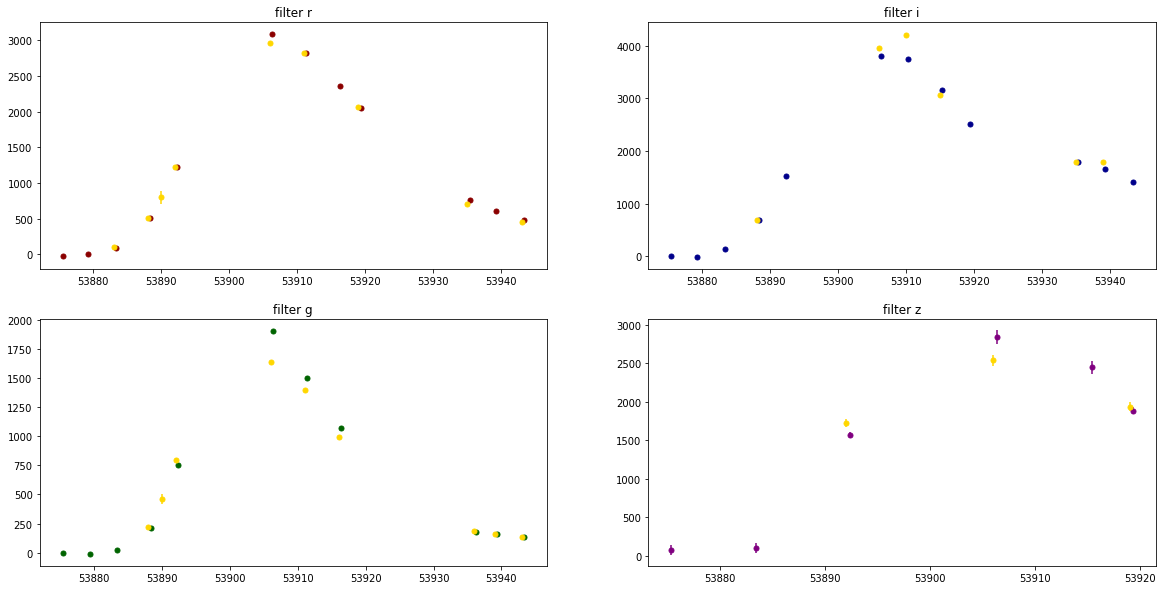

-----------------


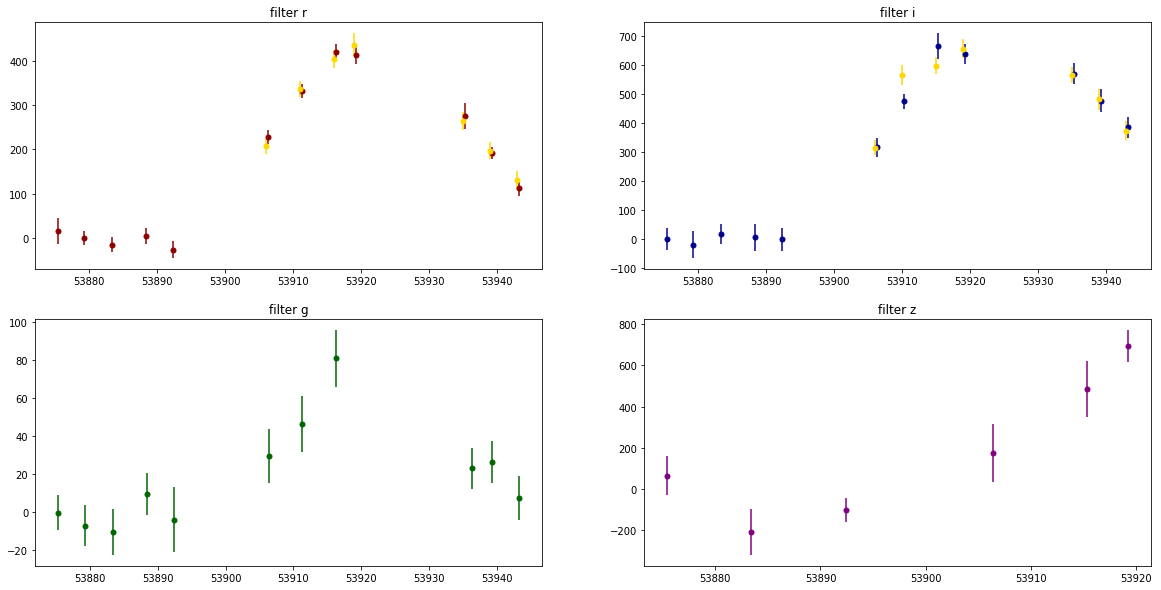

-----------------


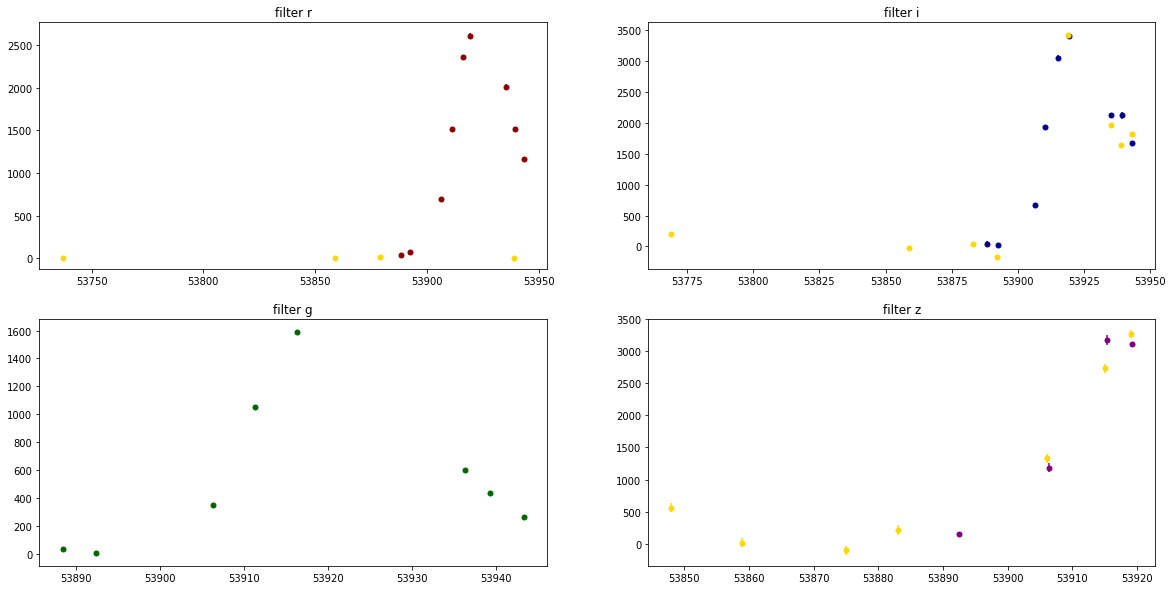

-----------------


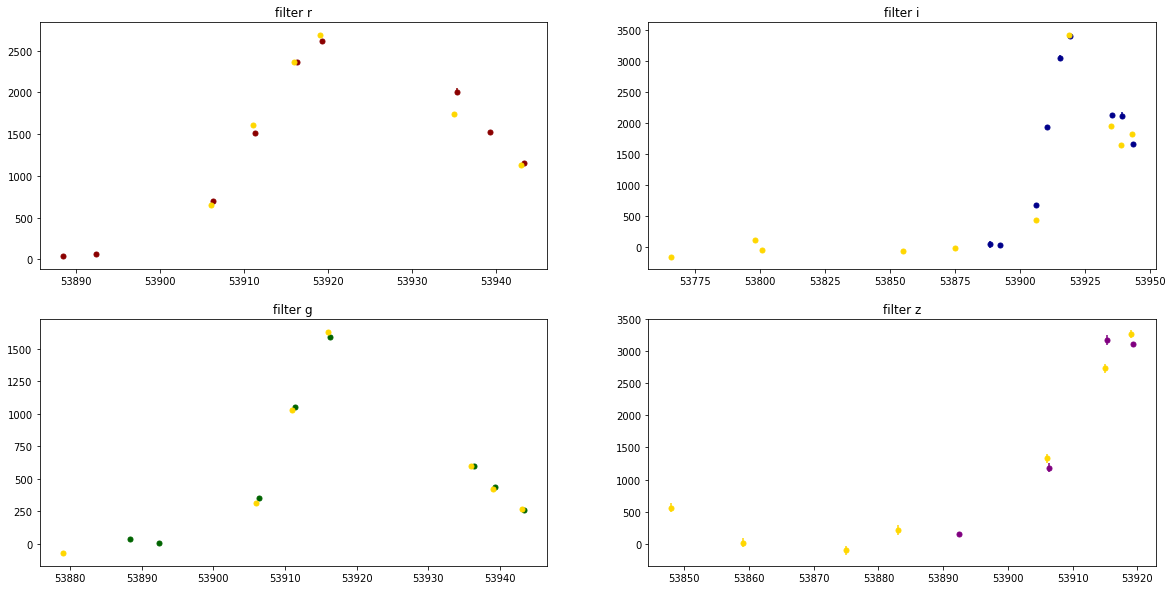

-----------------


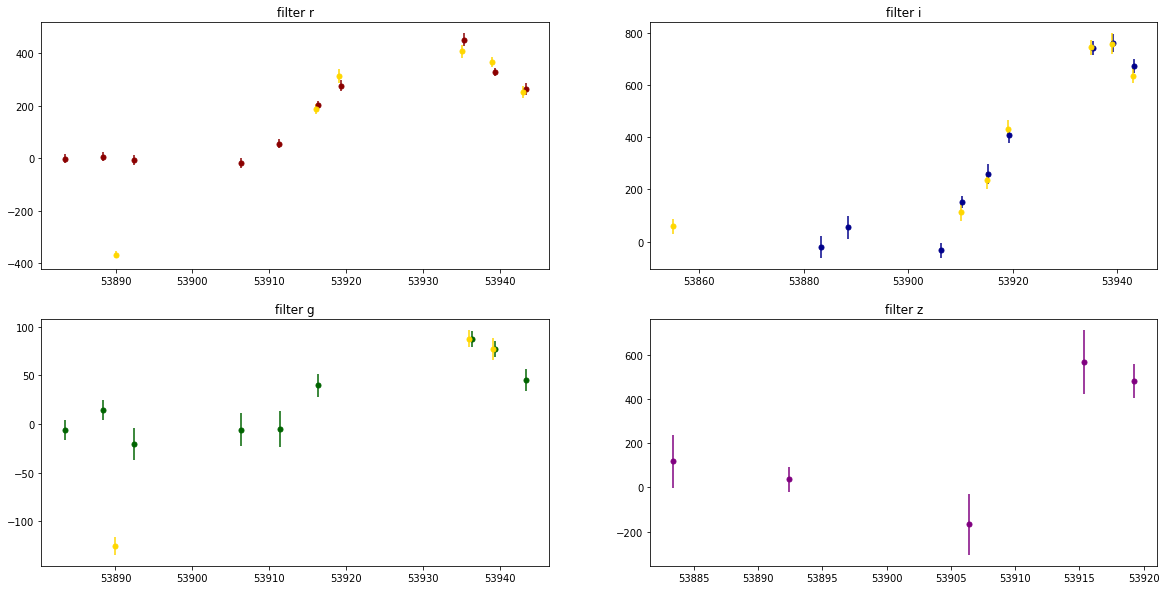

In [34]:


stack_colors_2 = {"sdssg":"gold", "sdssi":"gold", "sdssr":"gold", "sdssz":"gold"}
for match in matches_45:
    
    plt.figure(figsize=(20,10))
    print("-----------------")

    l1 = match[0]
    l2 = match[-1]

    n_factors = {}
    n_factors["sdssi"]=normalize_light_curve( l1,l2, "sdssi")
    n_factors["sdssg"]=normalize_light_curve( l1,l2, "sdssg")
    n_factors["sdssr"]=normalize_light_curve( l1,l2, "sdssr")
    n_factors["sdssz"]=normalize_light_curve( l1,l2, "sdssz")

    plt.subplot2grid((2, 2), (0, 0))
    plt.title("filter r")
    show_filter_light_curve(l1, snls_colors, "sdssr", n_factor = None, m_size=10)
    show_filter_light_curve(l2, stack_colors_2, "sdssr", n_factor = n_factors["sdssr"], m_size=10)

    plt.subplot2grid((2, 2), (0, 1))
    plt.title("filter i")
    show_filter_light_curve(l1, snls_colors, "sdssi", n_factor = None, m_size=10)
    show_filter_light_curve(l2, stack_colors_2, "sdssi", n_factor = n_factors["sdssi"], m_size=10)

    plt.subplot2grid((2, 2), (1, 0))
    plt.title("filter g")
    show_filter_light_curve(l1, snls_colors, "sdssg", n_factor = None, m_size=10)
    show_filter_light_curve(l2, stack_colors_2, "sdssg", n_factor = n_factors["sdssg"], m_size=10)

    plt.subplot2grid((2, 2), (1, 1))
    plt.title("filter z")
    show_filter_light_curve(l1, snls_colors, "sdssz", n_factor = None, m_size=10)
    show_filter_light_curve(l2, stack_colors_2, "sdssz", n_factor = n_factors["sdssz"], m_size=10)

    plt.show()

In [17]:
match[0]

mjd,zpsys,flux,ra,flux_error,dec,zp,bandpass
float64,str2,float64,float64,float64,float64,float64,str5
53883.35,ab,-21.308,3.73960310551,42.115,0.92391190464,25.0,sdssi
53883.37,ab,-1.35,3.73960310551,17.528,0.92391190464,25.0,sdssr
53883.38,ab,-5.9105,3.73960310551,10.449,0.92391190464,25.0,sdssg
53883.42,ab,118.22,3.73960310551,119.49,0.92391190464,25.0,sdssz
53888.36,ab,54.146,3.73960310551,43.076,0.92391190464,25.0,sdssi
53888.38,ab,6.1937,3.73960310551,18.203,0.92391190464,25.0,sdssr
53888.4,ab,14.376,3.73960310551,10.761,0.92391190464,25.0,sdssg
53892.35,ab,-5.454,3.73960310551,19.695,0.92391190464,25.0,sdssr
53892.37,ab,-20.835,3.73960310551,16.242,0.92391190464,25.0,sdssg
